In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier ,IsolationForest
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('dataset_with_random_nans.csv')
df.shape

(2200, 8)

In [3]:
df.head()

N     P     K  temperature   humidity        ph    rainfall label
0  90.0  42.0  43.0    20.879744  82.002744  6.502985  202.935536  rice
1  85.0  58.0  41.0    21.770462  80.319644  7.038096  226.655537  rice
2  60.0  55.0  44.0    23.004459  82.320763  7.840207  263.964248  rice
3  74.0  35.0  40.0    26.491096  80.158363       NaN  242.864034  rice
4  78.0  42.0  42.0    20.130175  81.604873  7.628473  262.717340  rice

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2189 non-null   float64
 1   P            2190 non-null   float64
 2   K            2189 non-null   float64
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2188 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(7), object(1)
memory usage: 137.6+ KB


In [5]:
df.isnull().sum()

N              11
P              10
K              11
temperature     0
humidity        0
ph             12
rainfall        0
label           0
dtype: int64

In [6]:
df.nunique()

N               137
P               117
K                73
temperature    2200
humidity       2200
ph             2188
rainfall       2200
label            22
dtype: int64

In [7]:
df['label'].aggregate(['unique']).sum()


array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [8]:
df.describe()

N            P            K  temperature     humidity  \
count  2189.000000  2190.000000  2189.000000  2200.000000  2200.000000   
mean     50.439927    53.401370    48.209228    25.616244    71.481779   
std      36.924681    33.026687    50.754878     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.000000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2188.000000  2200.000000  
mean      6.469870   103.463655  
std       0.774283    54.958389  
min       3.504752    20.211267  
25%       5.972172    64.551686  
50%       6.423558    94.867624  
75%       6.922373   124.267508  
max       9.935091   298.560117

In [9]:
def fill_nan_using_label_and_temp(df, target_cols, temp_col='temperature', label_col='label', nearest_n=5):
    for col in target_cols:
        nan_rows = df[df[col].isna()]
        for idx in nan_rows.index:
            label = df.loc[idx, label_col]
            temp = df.loc[idx, temp_col]

            # Subset data with same label and non-NaN in target column
            subset = df[(df[label_col] == label) & (~df[col].isna())]

            # Calculate absolute temperature difference
            subset['temp_diff'] = (subset[temp_col] - temp).abs()

            # Sort by closest temperature
            closest = subset.sort_values('temp_diff').head(nearest_n)

            # Compute the mean of the closest ones
            fill_value = closest[col].mean()

            # Fill the NaN
            df.loc[idx, col] = fill_value
    return df

# Target columns where NaNs need to be filled
target_cols = ['N', 'P', 'K', 'ph']

# Call the function with the dataset and target columns
df = fill_nan_using_label_and_temp(df, target_cols)


C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\522137476.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['temp_diff'] = (subset[temp_col] - temp).abs()
C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\522137476.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['temp_diff'] = (subset[temp_col] - temp).abs()
C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\522137476.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [10]:
# Target columns where NaNs need to be filled
target_cols = ['N', 'P', 'K', 'ph']

# Call the function with the dataset and target columns
df = fill_nan_using_label_and_temp(df, target_cols)

df

N     P     K  temperature   humidity        ph    rainfall   label
0      90.0  42.0  43.0    20.879744  82.002744  6.502985  202.935536    rice
1      85.0  58.0  41.0    21.770462  80.319644  7.038096  226.655537    rice
2      60.0  55.0  44.0    23.004459  82.320763  7.840207  263.964248    rice
3      74.0  35.0  40.0    26.491096  80.158363  6.503336  242.864034    rice
4      78.0  42.0  42.0    20.130175  81.604873  7.628473  262.717340    rice
...     ...   ...   ...          ...        ...       ...         ...     ...
2195  107.0  34.0  32.0    26.774637  66.413269  6.780064  177.774507  coffee
2196   99.0  15.0  27.0    27.417112  56.636362  6.086922  127.924610  coffee
2197  118.0  33.0  30.0    24.131797  67.225123  6.362608  173.322839  coffee
2198  117.0  32.0  34.0    26.272418  52.127394  6.758793  127.175293  coffee
2199  104.0  18.0  30.0    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

In [11]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [12]:
df.describe()

N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.524727    53.377636    48.150818    25.616244    71.481779   
std      36.921495    32.983737    50.648262     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.200000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469344   103.463655  
std       0.772636    54.958389  
min       3.504752    20.211267  
25%       5.972172    64.551686  
50%       6.423558    94.867624  
75%       6.920131   124.267508  
max       9.935091   298.560117

In [13]:
df.nunique()

N               146
P               125
K                81
temperature    2200
humidity       2200
ph             2200
rainfall       2200
label            22
dtype: int64

# Data Analaysis

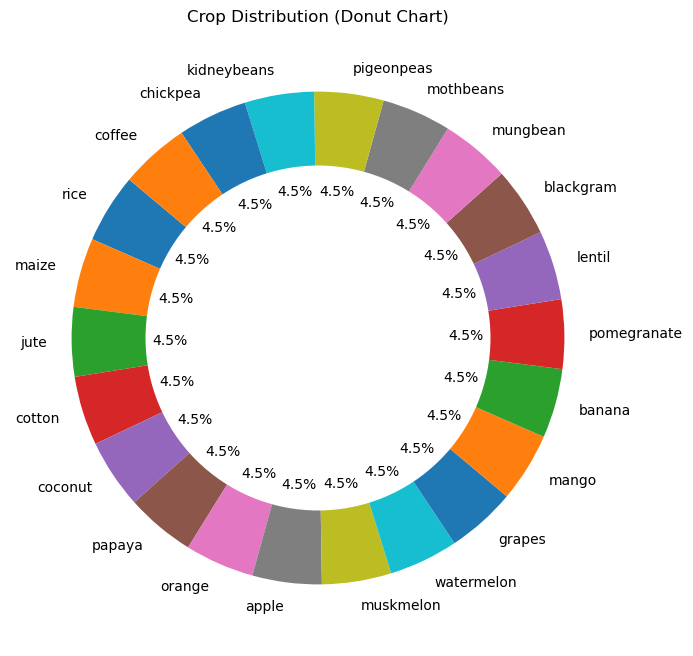

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
label_counts = df['label'].value_counts()
wedges, texts, autotexts = ax.pie(label_counts, labels = label_counts.index, autopct='%1.1f%%', startangle=140 )
# Draw the circle for donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Crop Distribution (Donut Chart)')
plt.show()


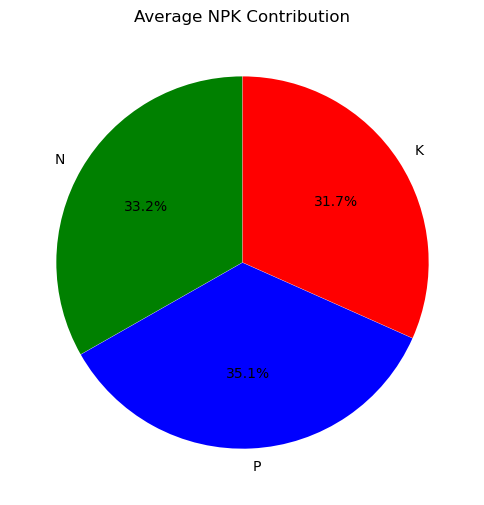

In [15]:
npk_means = df[['N', 'P', 'K']].mean()

plt.figure(figsize=(6, 7))
plt.pie(npk_means, labels=npk_means.index, autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red'],explode=[.001,.001,.001])
plt.title('Average NPK Contribution')
plt.show()


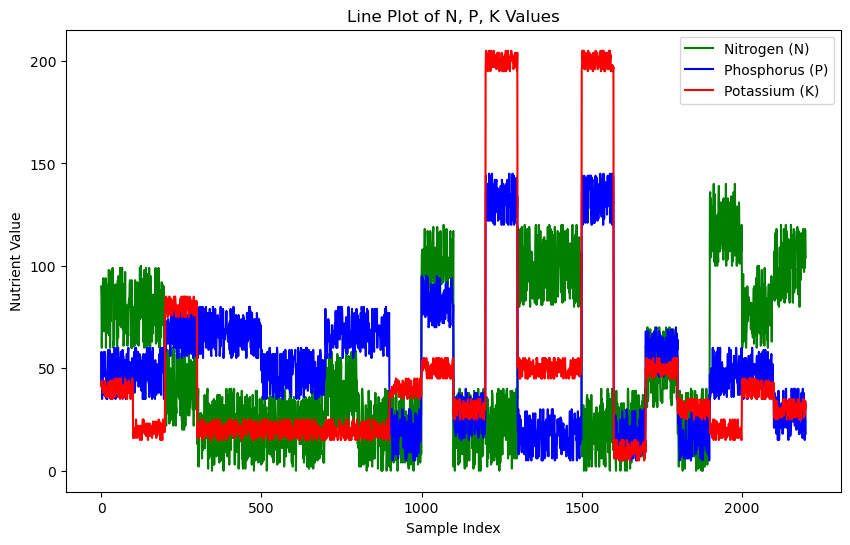

In [16]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['N'], label='Nitrogen (N)', color='green')
plt.plot(df.index, df['P'], label='Phosphorus (P)', color='blue')
plt.plot(df.index, df['K'], label='Potassium (K)', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Nutrient Value')
plt.title('Line Plot of N, P, K Values')
plt.legend()

plt.show()


# Crop Count Distribution using Bar Plot

we use a Bar Plot to visualize the count of each crop type present in our dataset.

Why is this useful?

Gives a clear picture of how balanced or imbalanced the dataset is in terms of crop labels.

Helps identify if certain crops dominate the dataset, which could affect the model training (bias).

A great starting point to understand data distribution of the target variable (crop types).

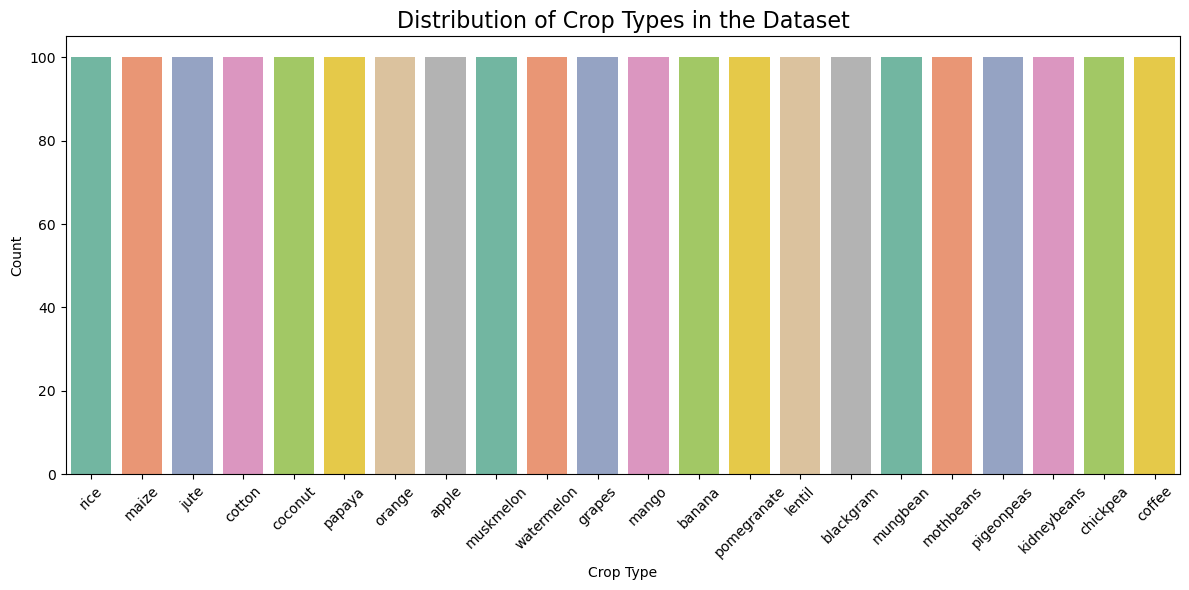

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df, palette='Set2', order=df['label'].value_counts().index)
plt.title('Distribution of Crop Types in the Dataset', fontsize=16)
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram

###Histograms using Matplotlib for Temperature, Humidity, pH, Rainfall, N, P, K

#####"The following histograms represent the distribution of key agricultural features such as Nitrogen (N), Phosphorus (P), Potassium (K), Temperature, Humidity, pH, and Rainfall across the dataset. Understanding these distributions helps in identifying data patterns, skewness, and potential outliers. This forms the basis for further analysis and model building in our Crop Recommendation System."

C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\1289801778.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, 1)


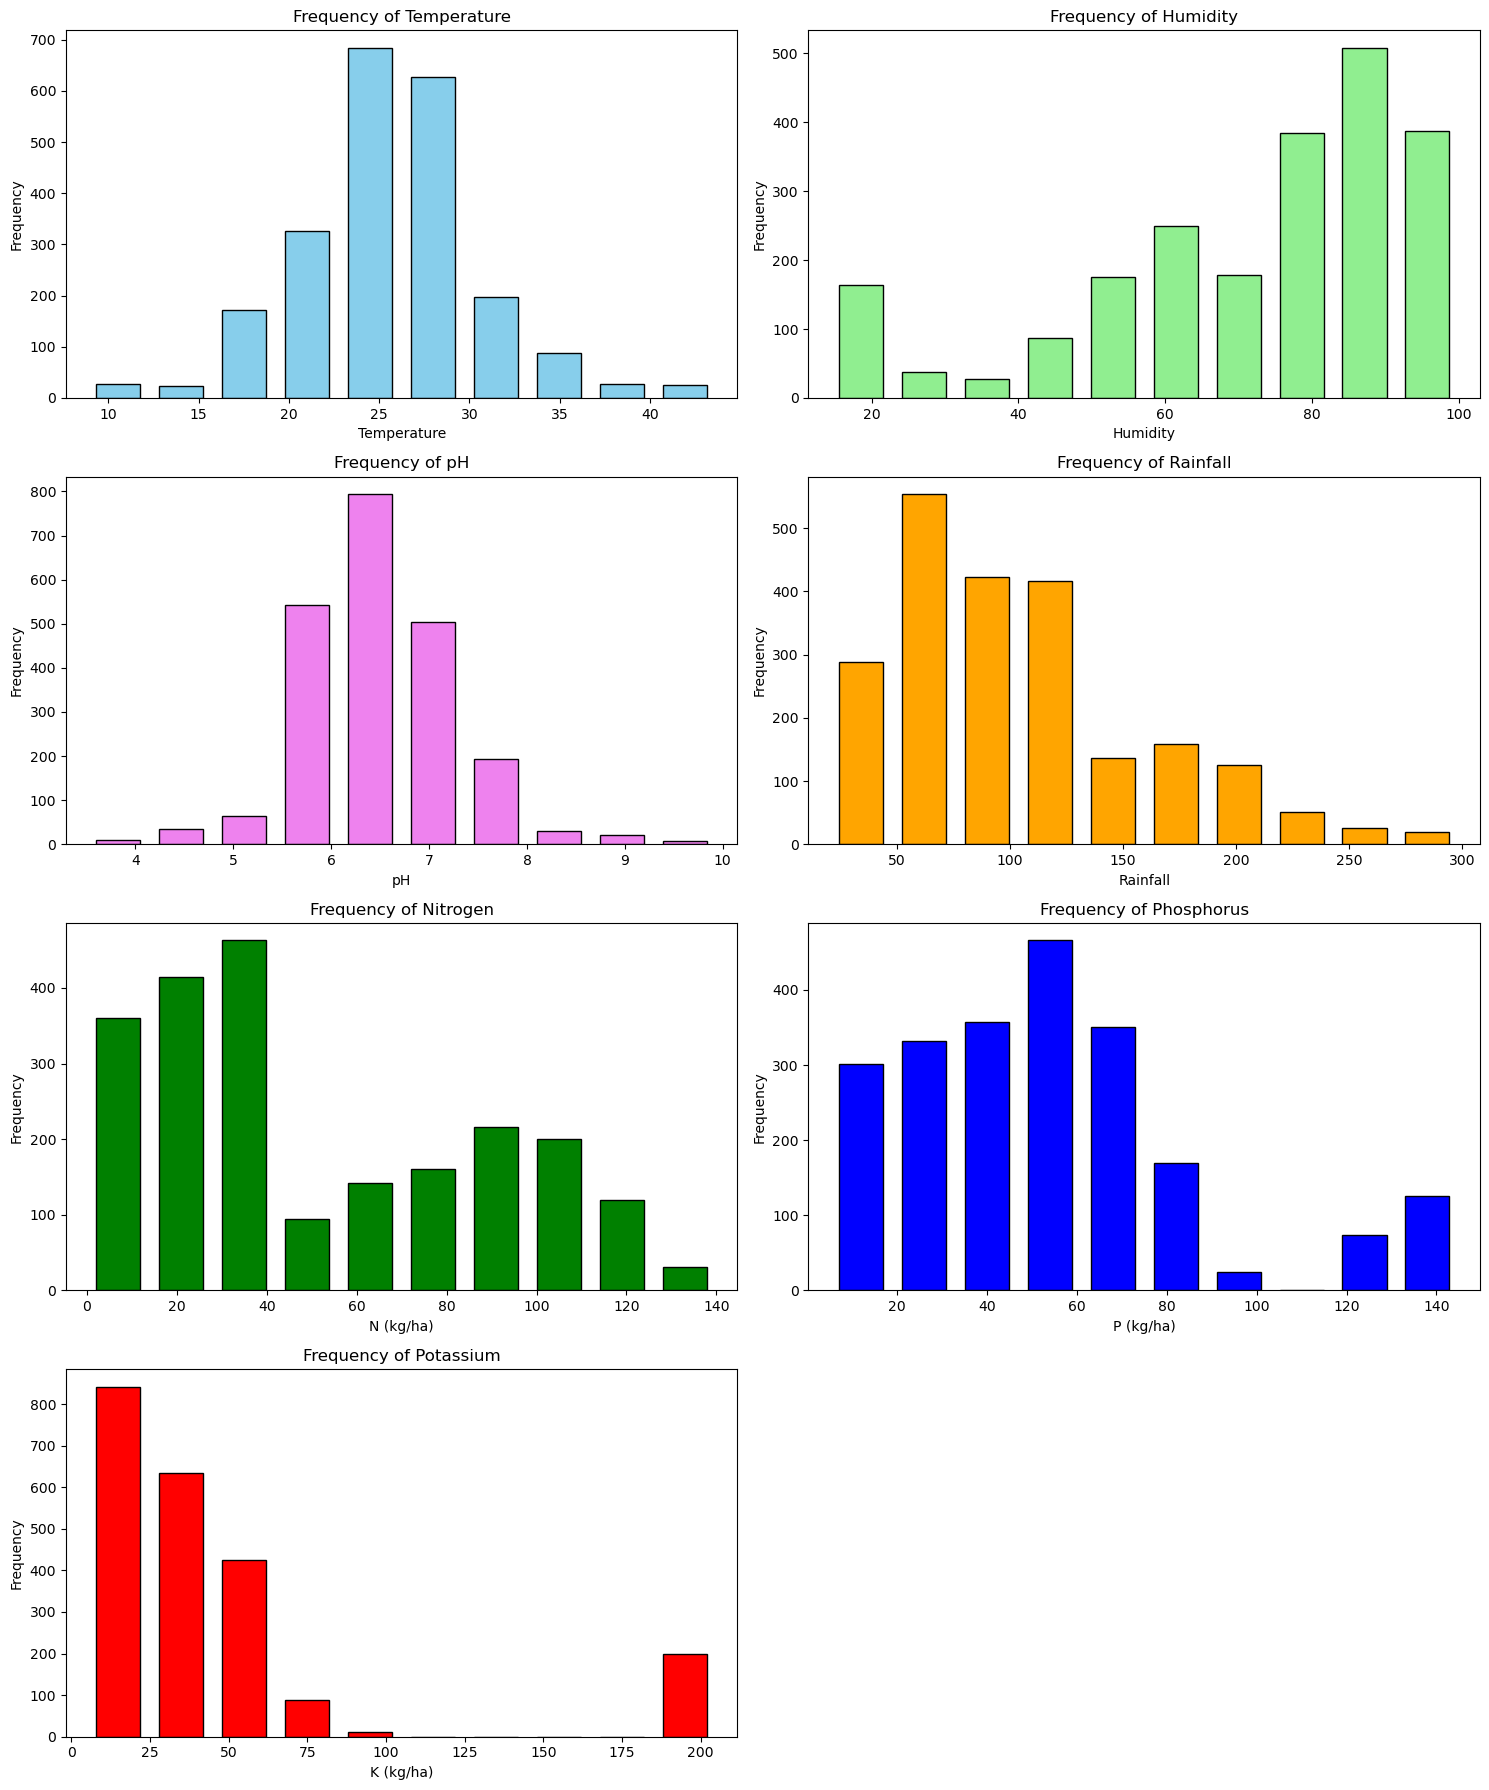

In [18]:

# Create a big figure
fig, ax = plt.subplots(figsize=(15, 18))

# Temperature
plt.subplot(4, 2, 1)
df['temperature'].plot(kind='hist', rwidth=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Frequency of Temperature')

# Humidity
plt.subplot(4, 2, 2)
df['humidity'].plot(kind='hist', rwidth=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Frequency of Humidity')

# pH
plt.subplot(4, 2, 3)
df['ph'].plot(kind='hist', rwidth=0.7, color='violet', edgecolor='black')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.title('Frequency of pH')

# Rainfall
plt.subplot(4, 2, 4)
df['rainfall'].plot(kind='hist', rwidth=0.7, color='orange', edgecolor='black')
plt.xlabel('Rainfall')
plt.ylabel('Frequency')
plt.title('Frequency of Rainfall')

# Nitrogen (N)
plt.subplot(4, 2, 5)
df['N'].plot(kind='hist', rwidth=0.7, color='green', edgecolor='black')
plt.xlabel('N (kg/ha)')
plt.ylabel('Frequency')
plt.title('Frequency of Nitrogen')

# Phosphorus (P)
plt.subplot(4, 2, 6)
df['P'].plot(kind='hist', rwidth=0.7, color='blue', edgecolor='black')
plt.xlabel('P (kg/ha)')
plt.ylabel('Frequency')
plt.title('Frequency of Phosphorus')

# Potassium (K)
plt.subplot(4, 2, 7)
df['K'].plot(kind='hist', rwidth=0.7, color='red', edgecolor='black')
plt.xlabel('K (kg/ha)')
plt.ylabel('Frequency')
plt.title('Frequency of Potassium')

plt.tight_layout()
plt.show()

###Histograms with KDE using Seaborn for deeper distribution understanding

c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

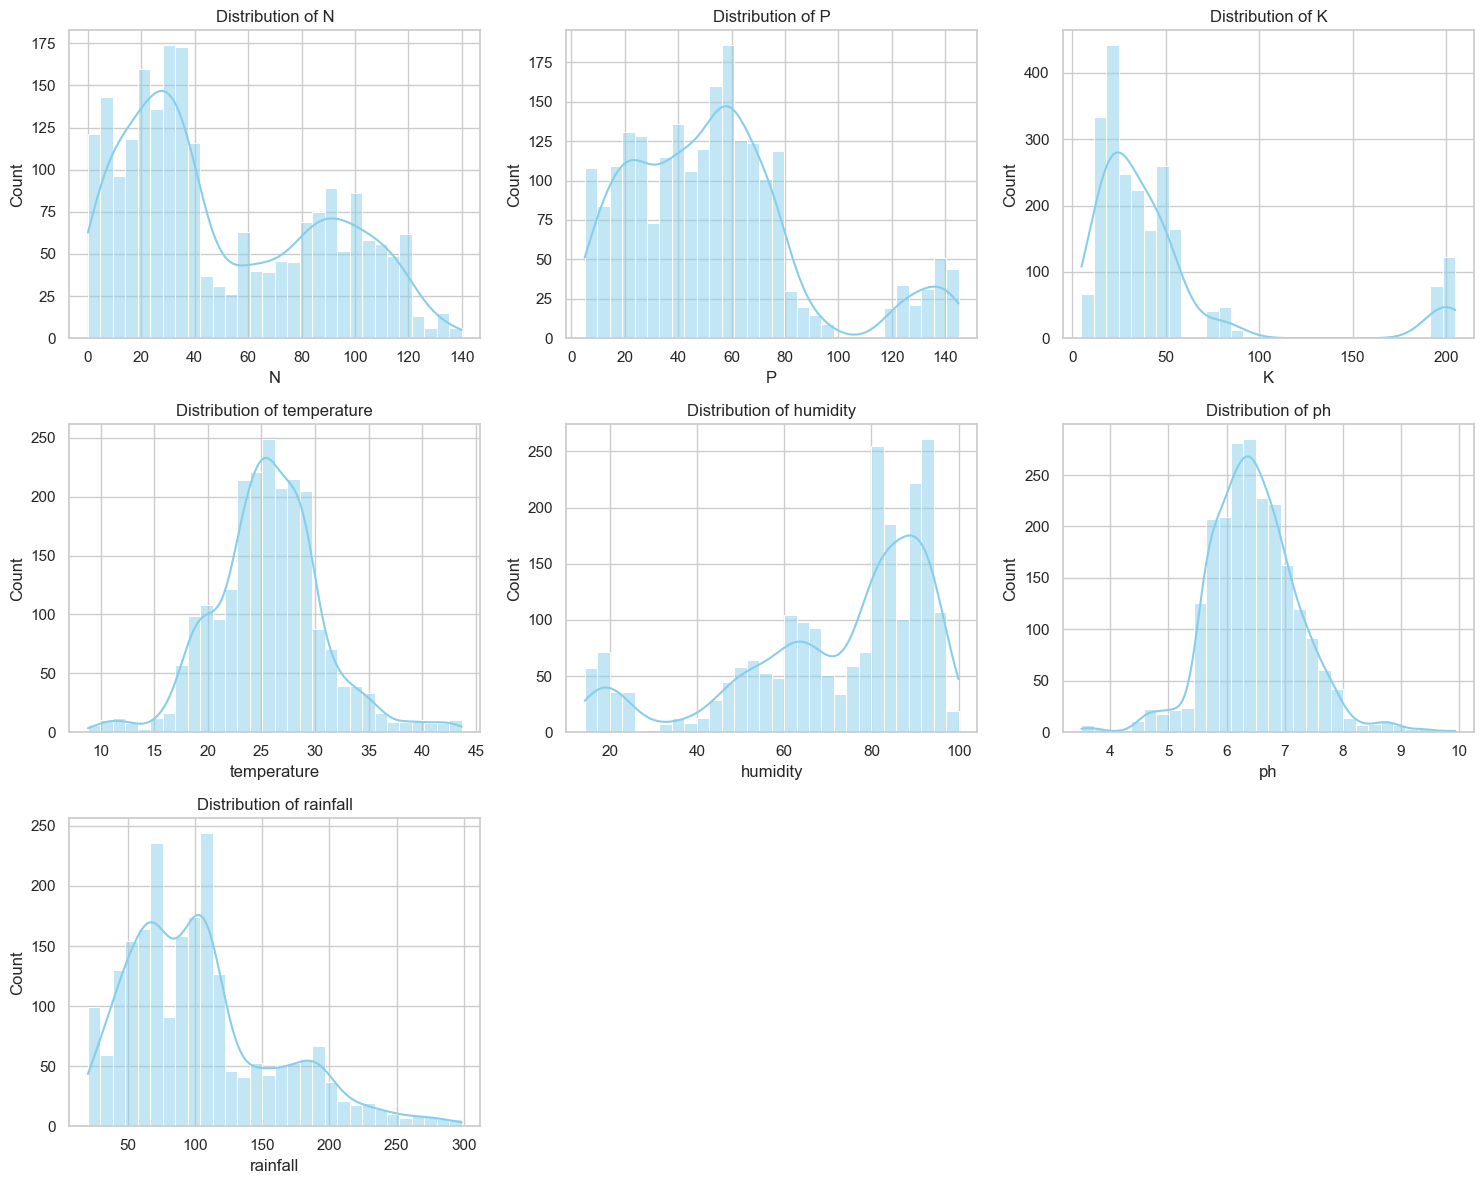

In [19]:
sns.set(style="whitegrid")

# List of numeric columns you want to plot
numeric_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Plotting histograms for each numeric feature
plt.figure(figsize=(15, 12))

for idx, col in enumerate(numeric_columns):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=12)

plt.tight_layout()
plt.show()

#Box Plots

###Basic Box Plot: General Outlier Detection

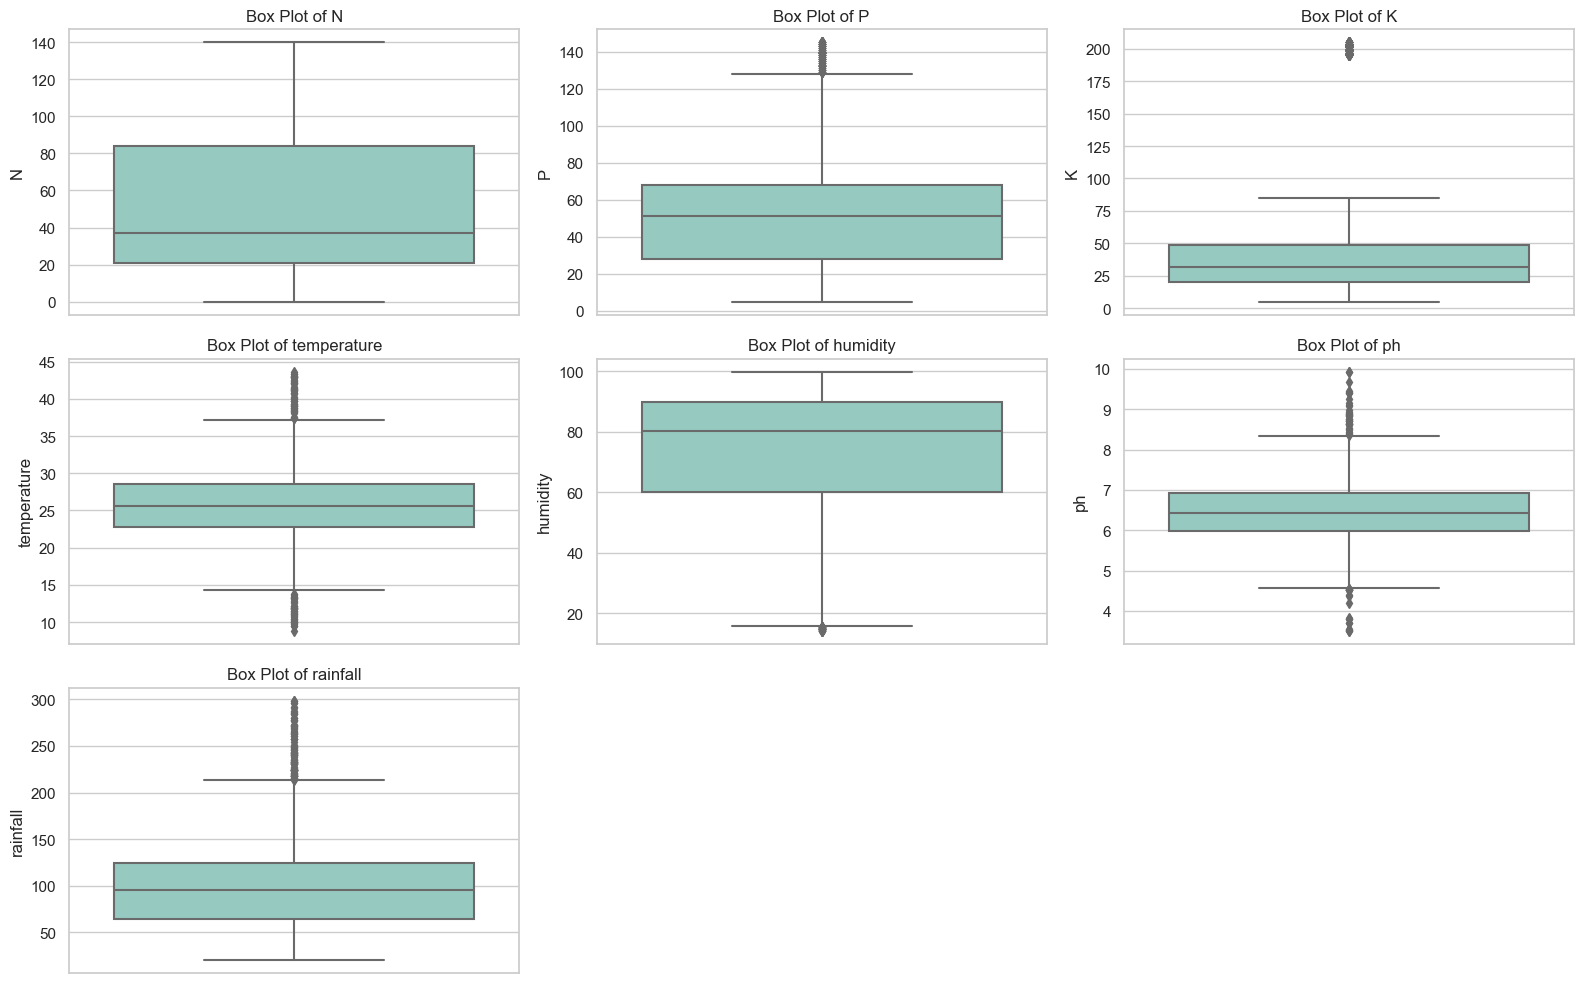

In [20]:


plt.figure(figsize=(16, 10))

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=feature, data=df, palette='Set3')
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


###Grouped Box Plot: Crop-wise Feature Spread Analysis

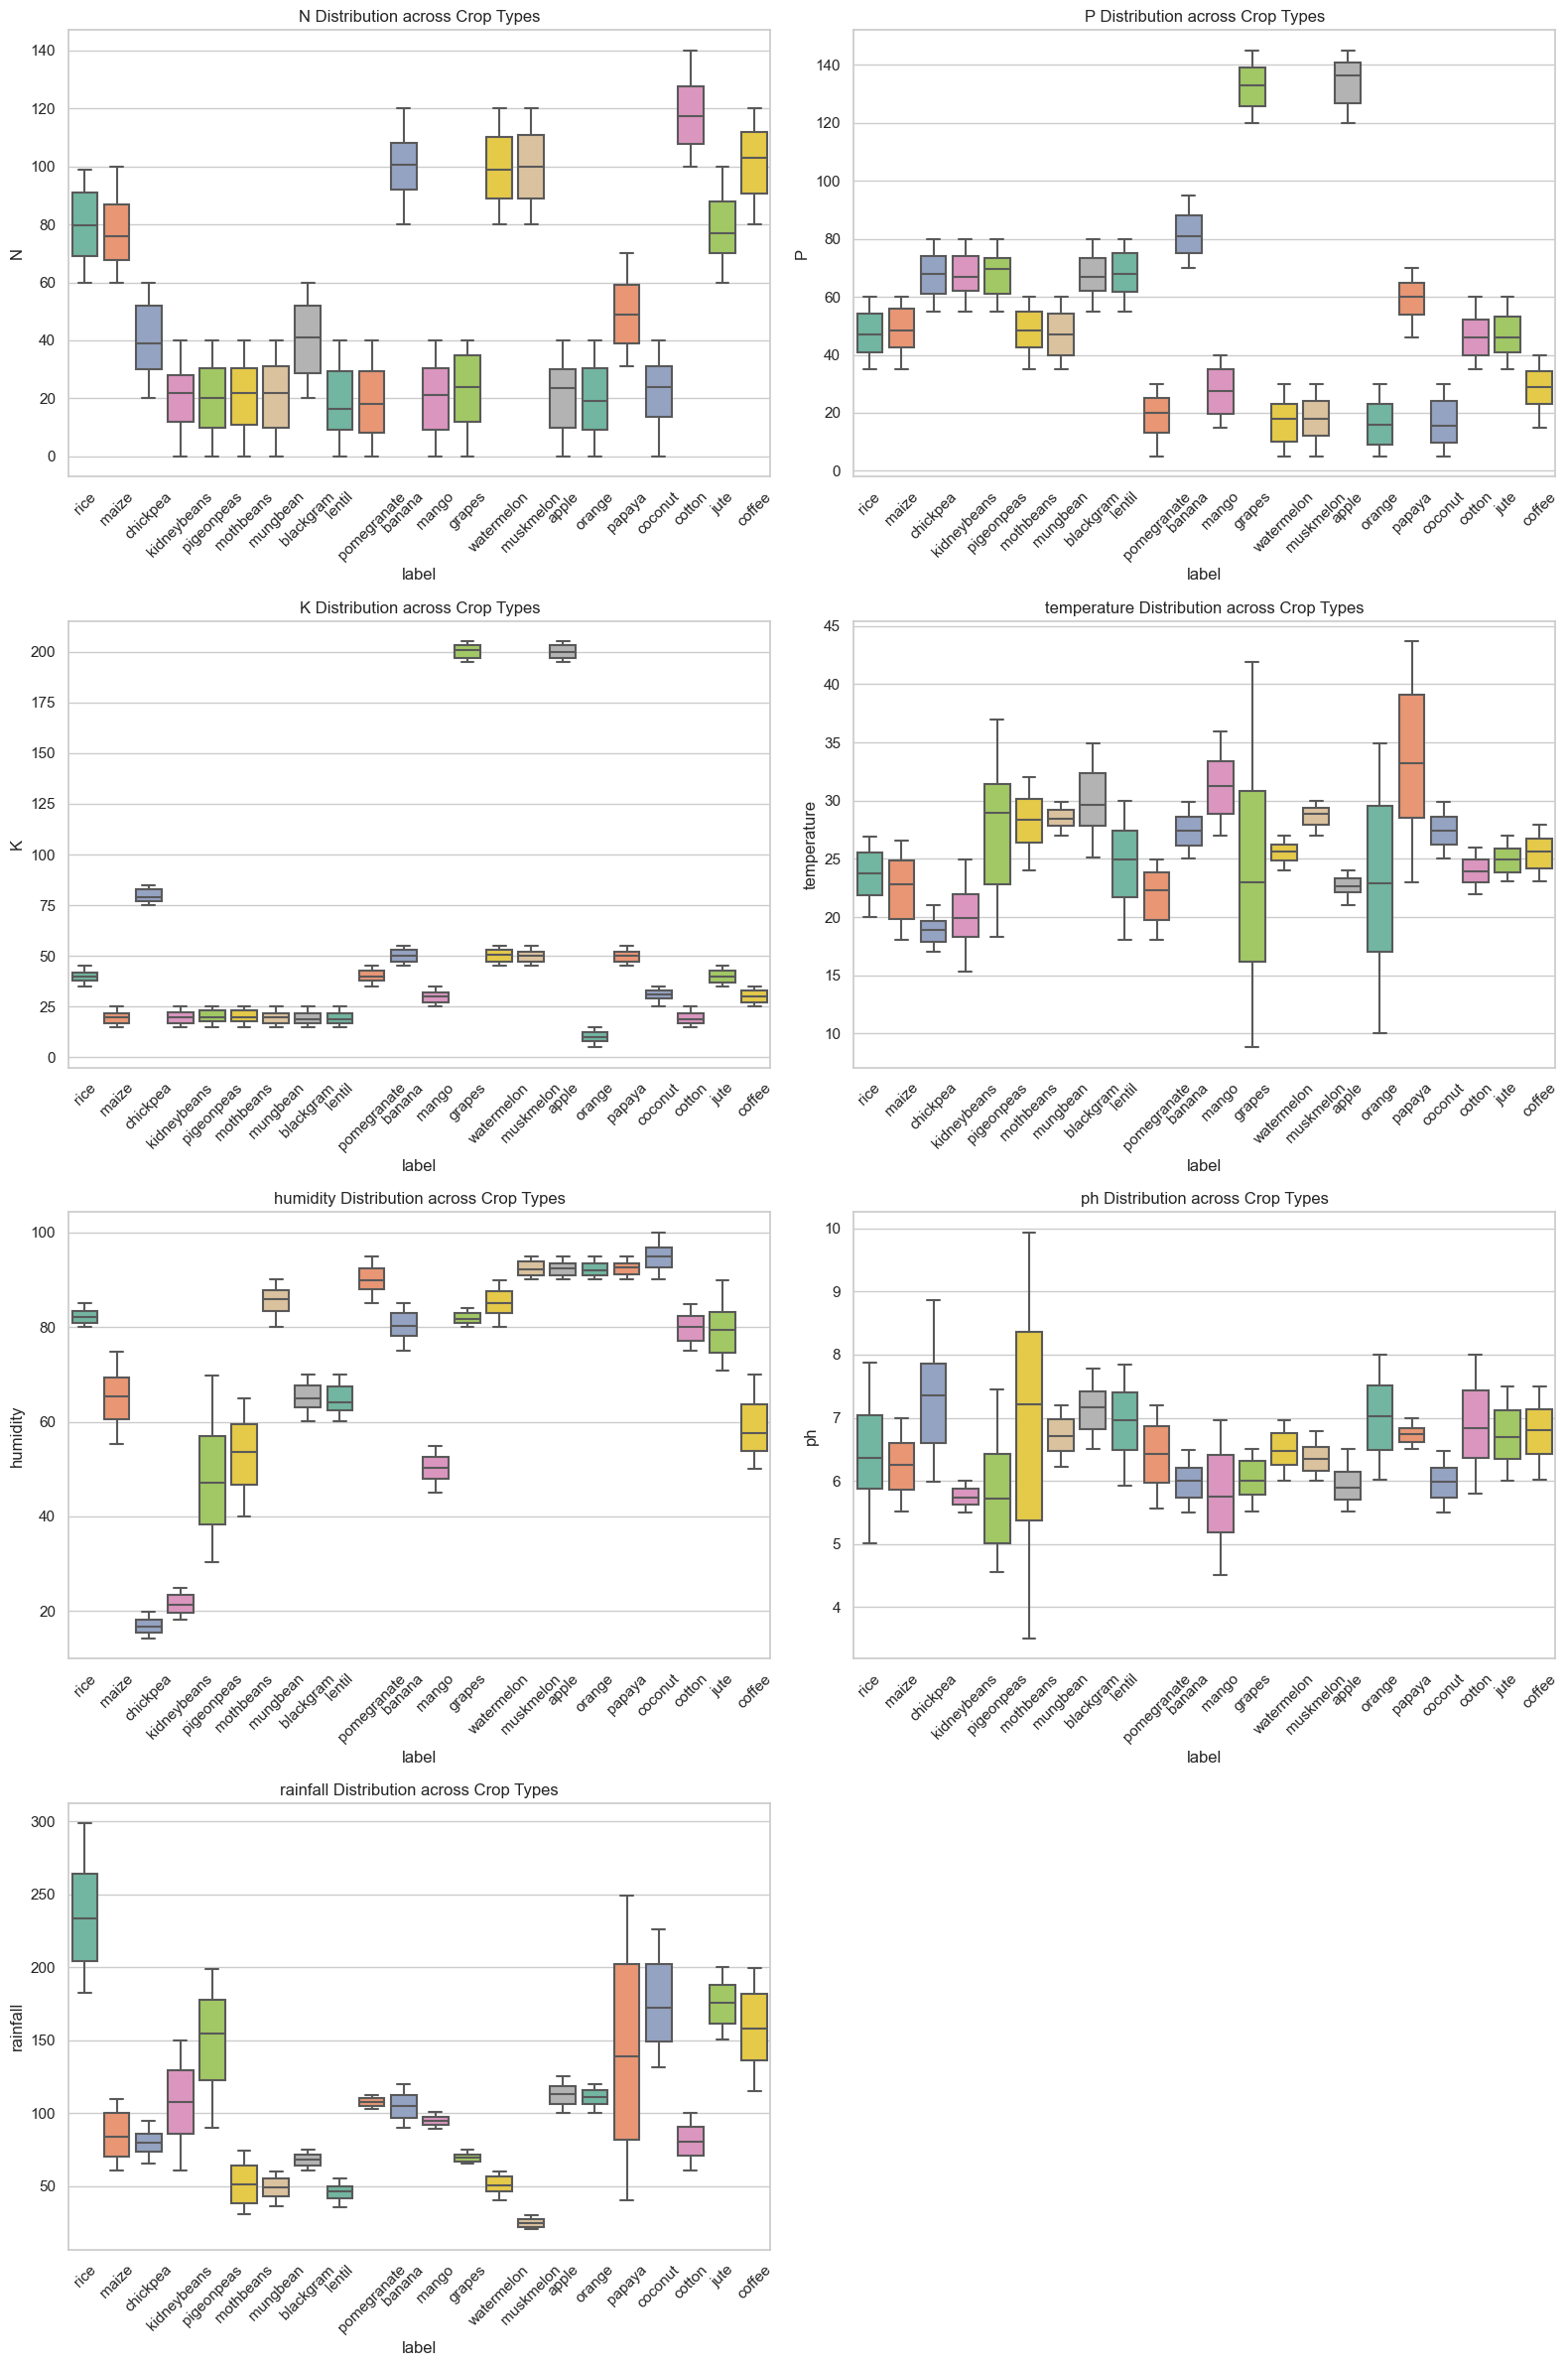

In [21]:
plt.figure(figsize=(16, 24))

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(x='label', y=feature, data=df, palette='Set2')
    plt.title(f'{feature} Distribution across Crop Types')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#Correlation Heatmap

The correlation heatmap below visualizes the strength of relationships between various features in the dataset, including soil nutrients, environmental conditions, and rainfall. This is crucial for understanding how independent variables like Nitrogen, Phosphorus, Potassium, temperature, humidity, pH, and rainfall interact with each other.

Usefulness:

Helps identify strongly correlated features that may impact crop growth.

Assists in feature selection by revealing multicollinearity (high correlation between independent variables).

Provides insights into which environmental factors are closely related, influencing the crop recommendation logic.

"The correlation heatmap revealed that Phosphorus (P) and Potassium (K) share a strong positive relationship, indicating they might impact crop yield similarly. Other features like temperature, pH, and rainfall show weak correlations, supporting their independent effect on crop growth."

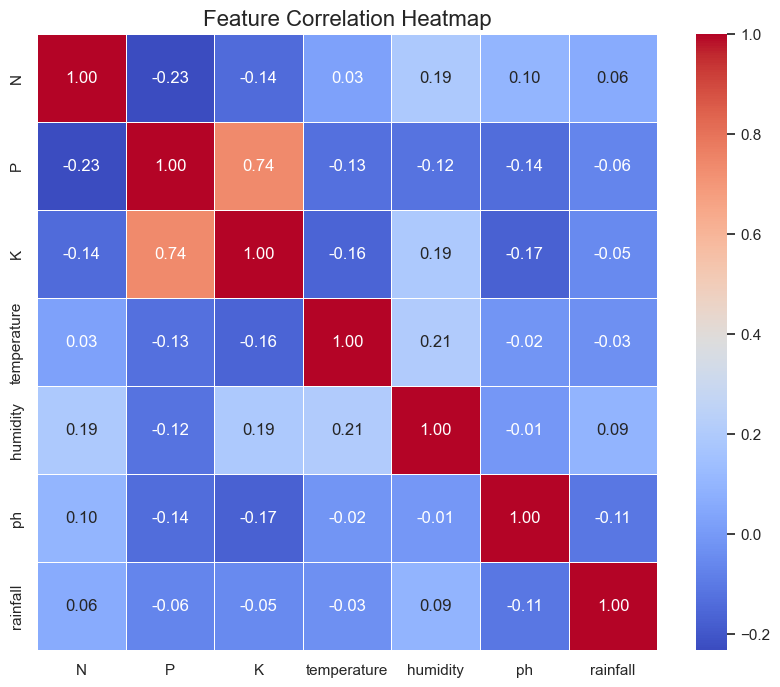

In [22]:

# Calculate the correlation matrix
corr_matrix = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']].corr()

# Set the plot size and style
plt.figure(figsize=(10, 8))
sns.set(style="white")

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()


# Comparative Feature Distribution using Violin Plot

we visualize the distribution of key features like Nitrogen (N), Phosphorus (P), Potassium (K), Temperature, Humidity, pH, and Rainfall across different crop types using Violin Plots.

A Violin Plot combines a boxplot and a kernel density estimate (KDE), showing:

The distribution shape of the data for each crop

Median, quartiles, and outliers

Why is this useful?

Helps us understand how different crops have varying nutrient requirements and environmental needs

Highlights which features are well-separated across crops and are potentially important for prediction

Assists in feature selection by showing variability per crop

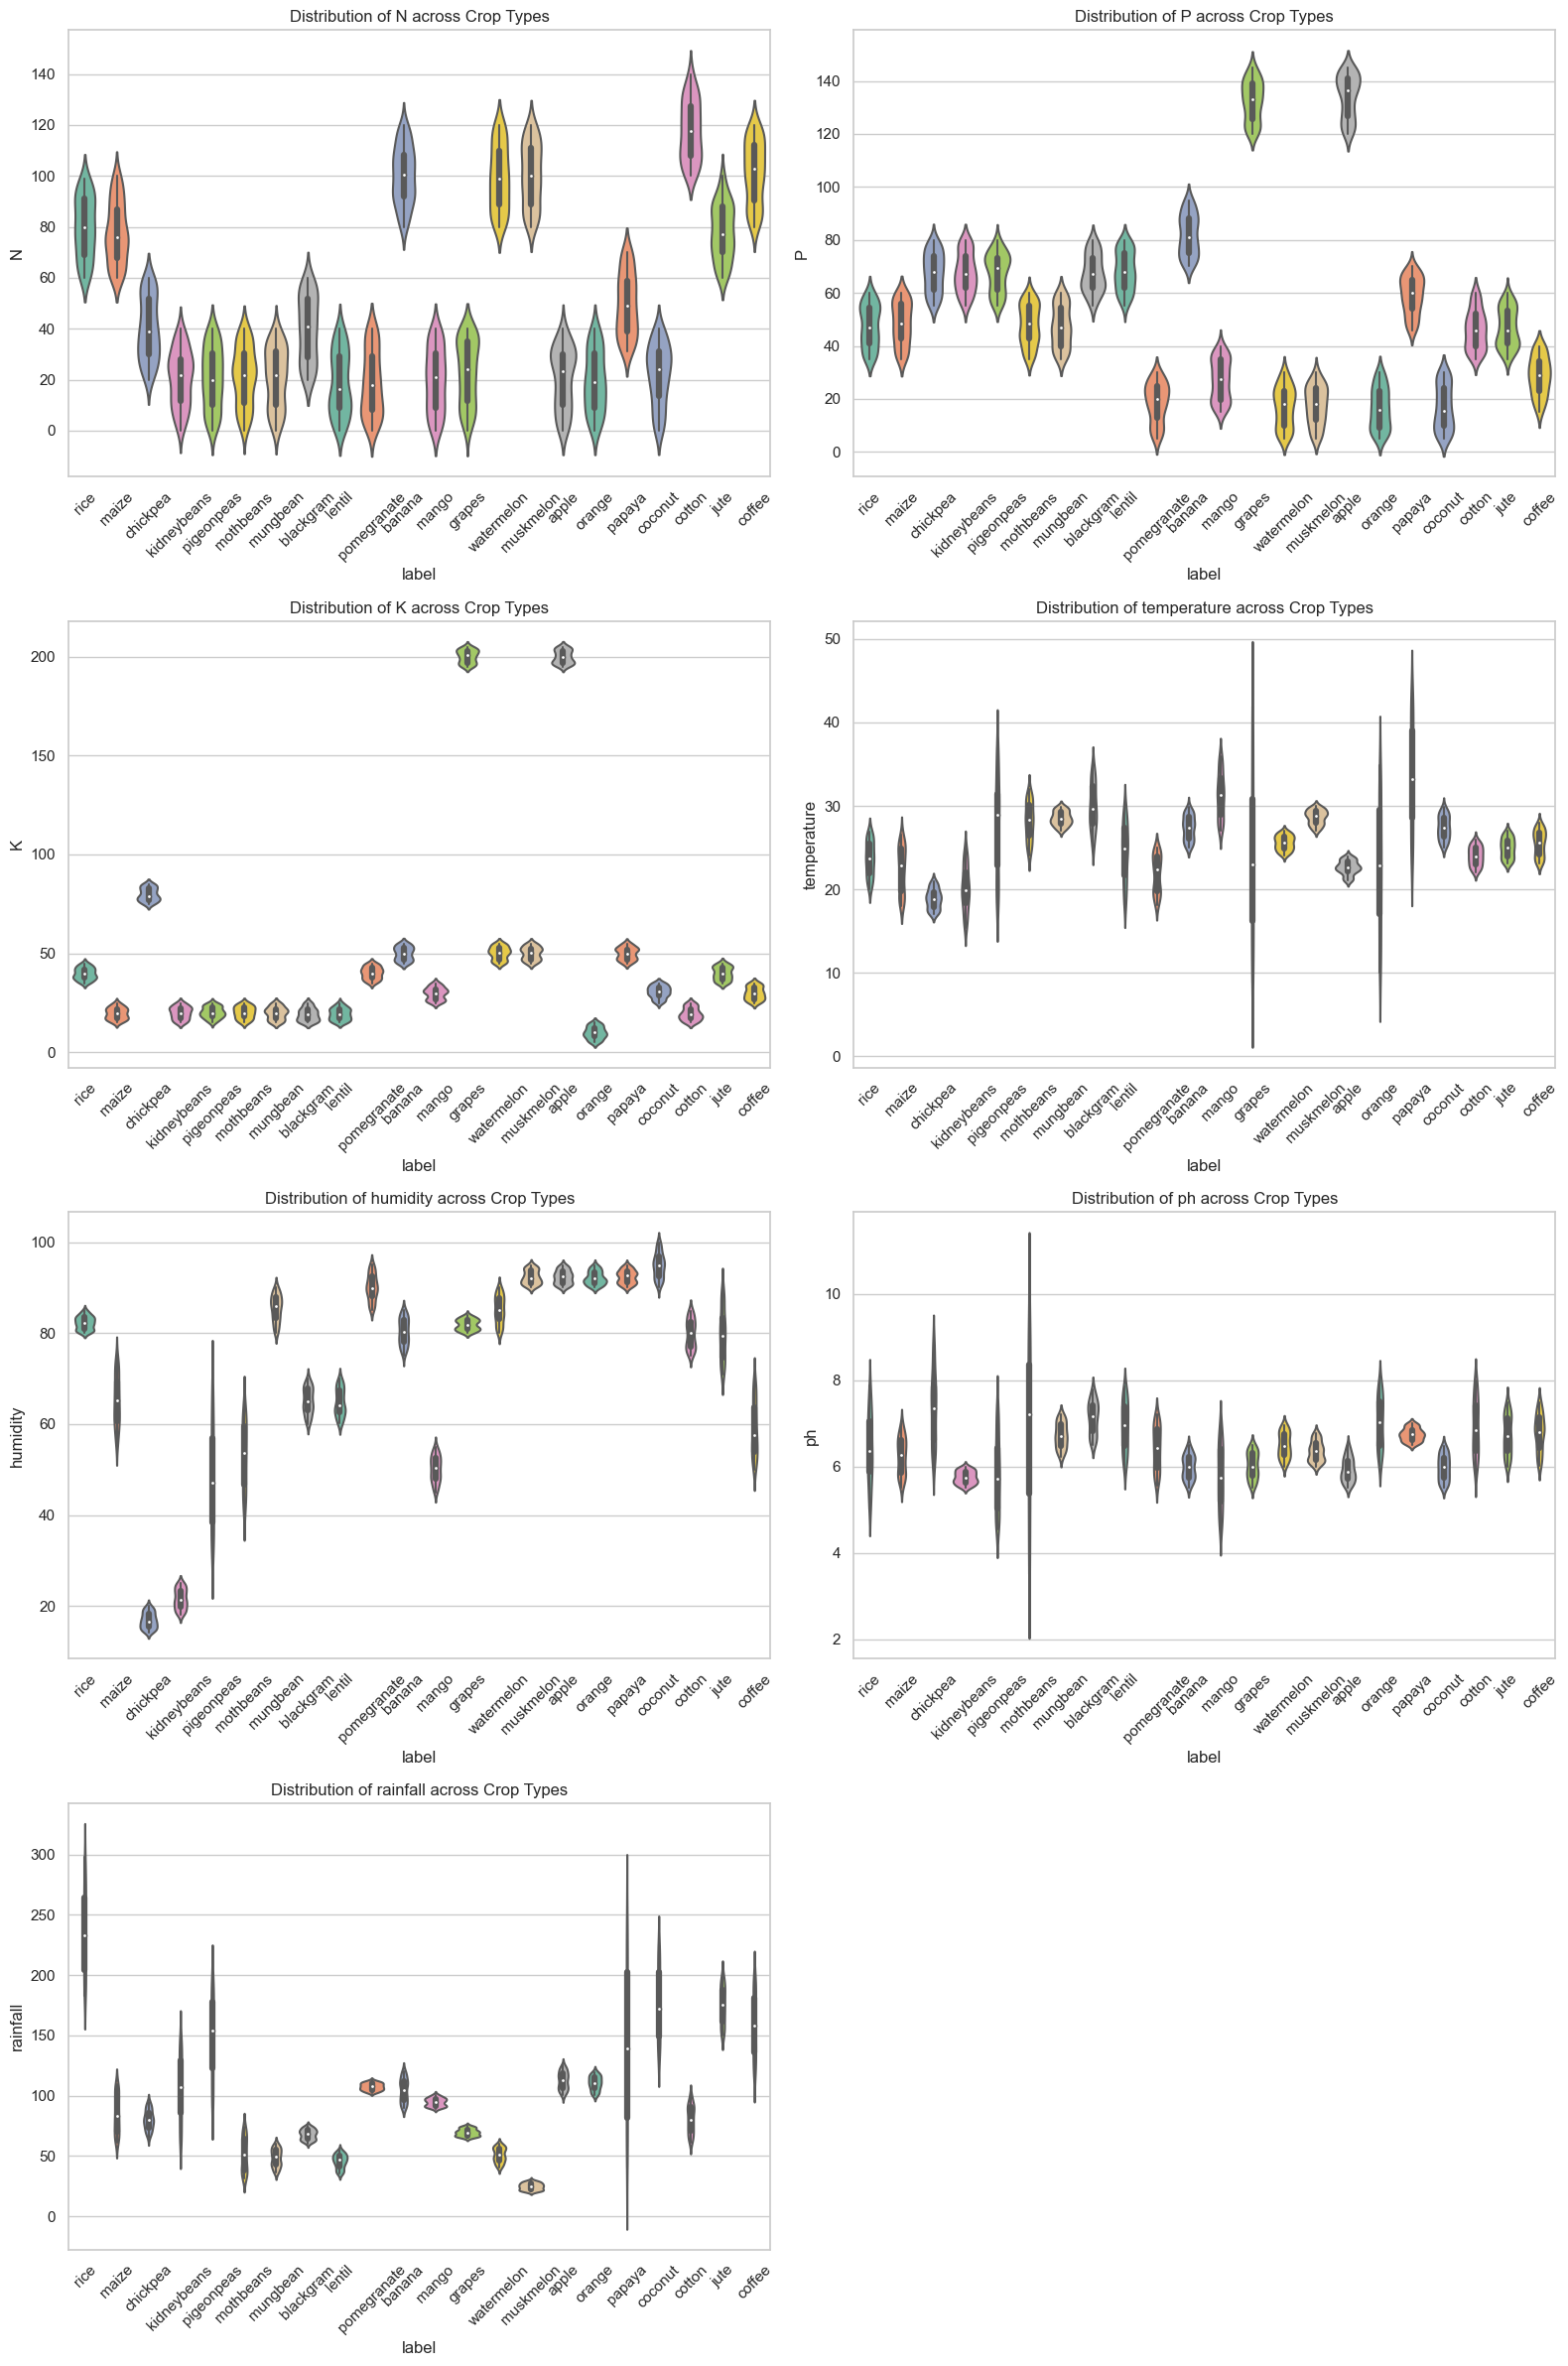

In [23]:

sns.set(style="whitegrid")
plt.figure(figsize=(16, 24))

# List of features to plot
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Loop through features and create a violin plot for each
for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.violinplot(x='label', y=feature, data=df, palette='Set2')
    plt.title(f'Distribution of {feature} across Crop Types', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Multivariate Analysis using Pairplot


we use Seaborn's pairplot to visualize pairwise relationships between multiple numerical features in the dataset.

A pairplot combines scatter plots, histograms, and KDEs into one grid:

Diagonal: shows the distribution (histogram) of each feature

Off-diagonal: shows scatter plots between pairs of features

Usefulness of Pairplot:

Helps us observe relationships between features like Nitrogen vs Phosphorus or Rainfall vs Humidity.

Highlights clusters or groups that may belong to specific crops (labels).

Helps identify if some features are linearly correlated or if their relationship is non-linear.



c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rahul\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

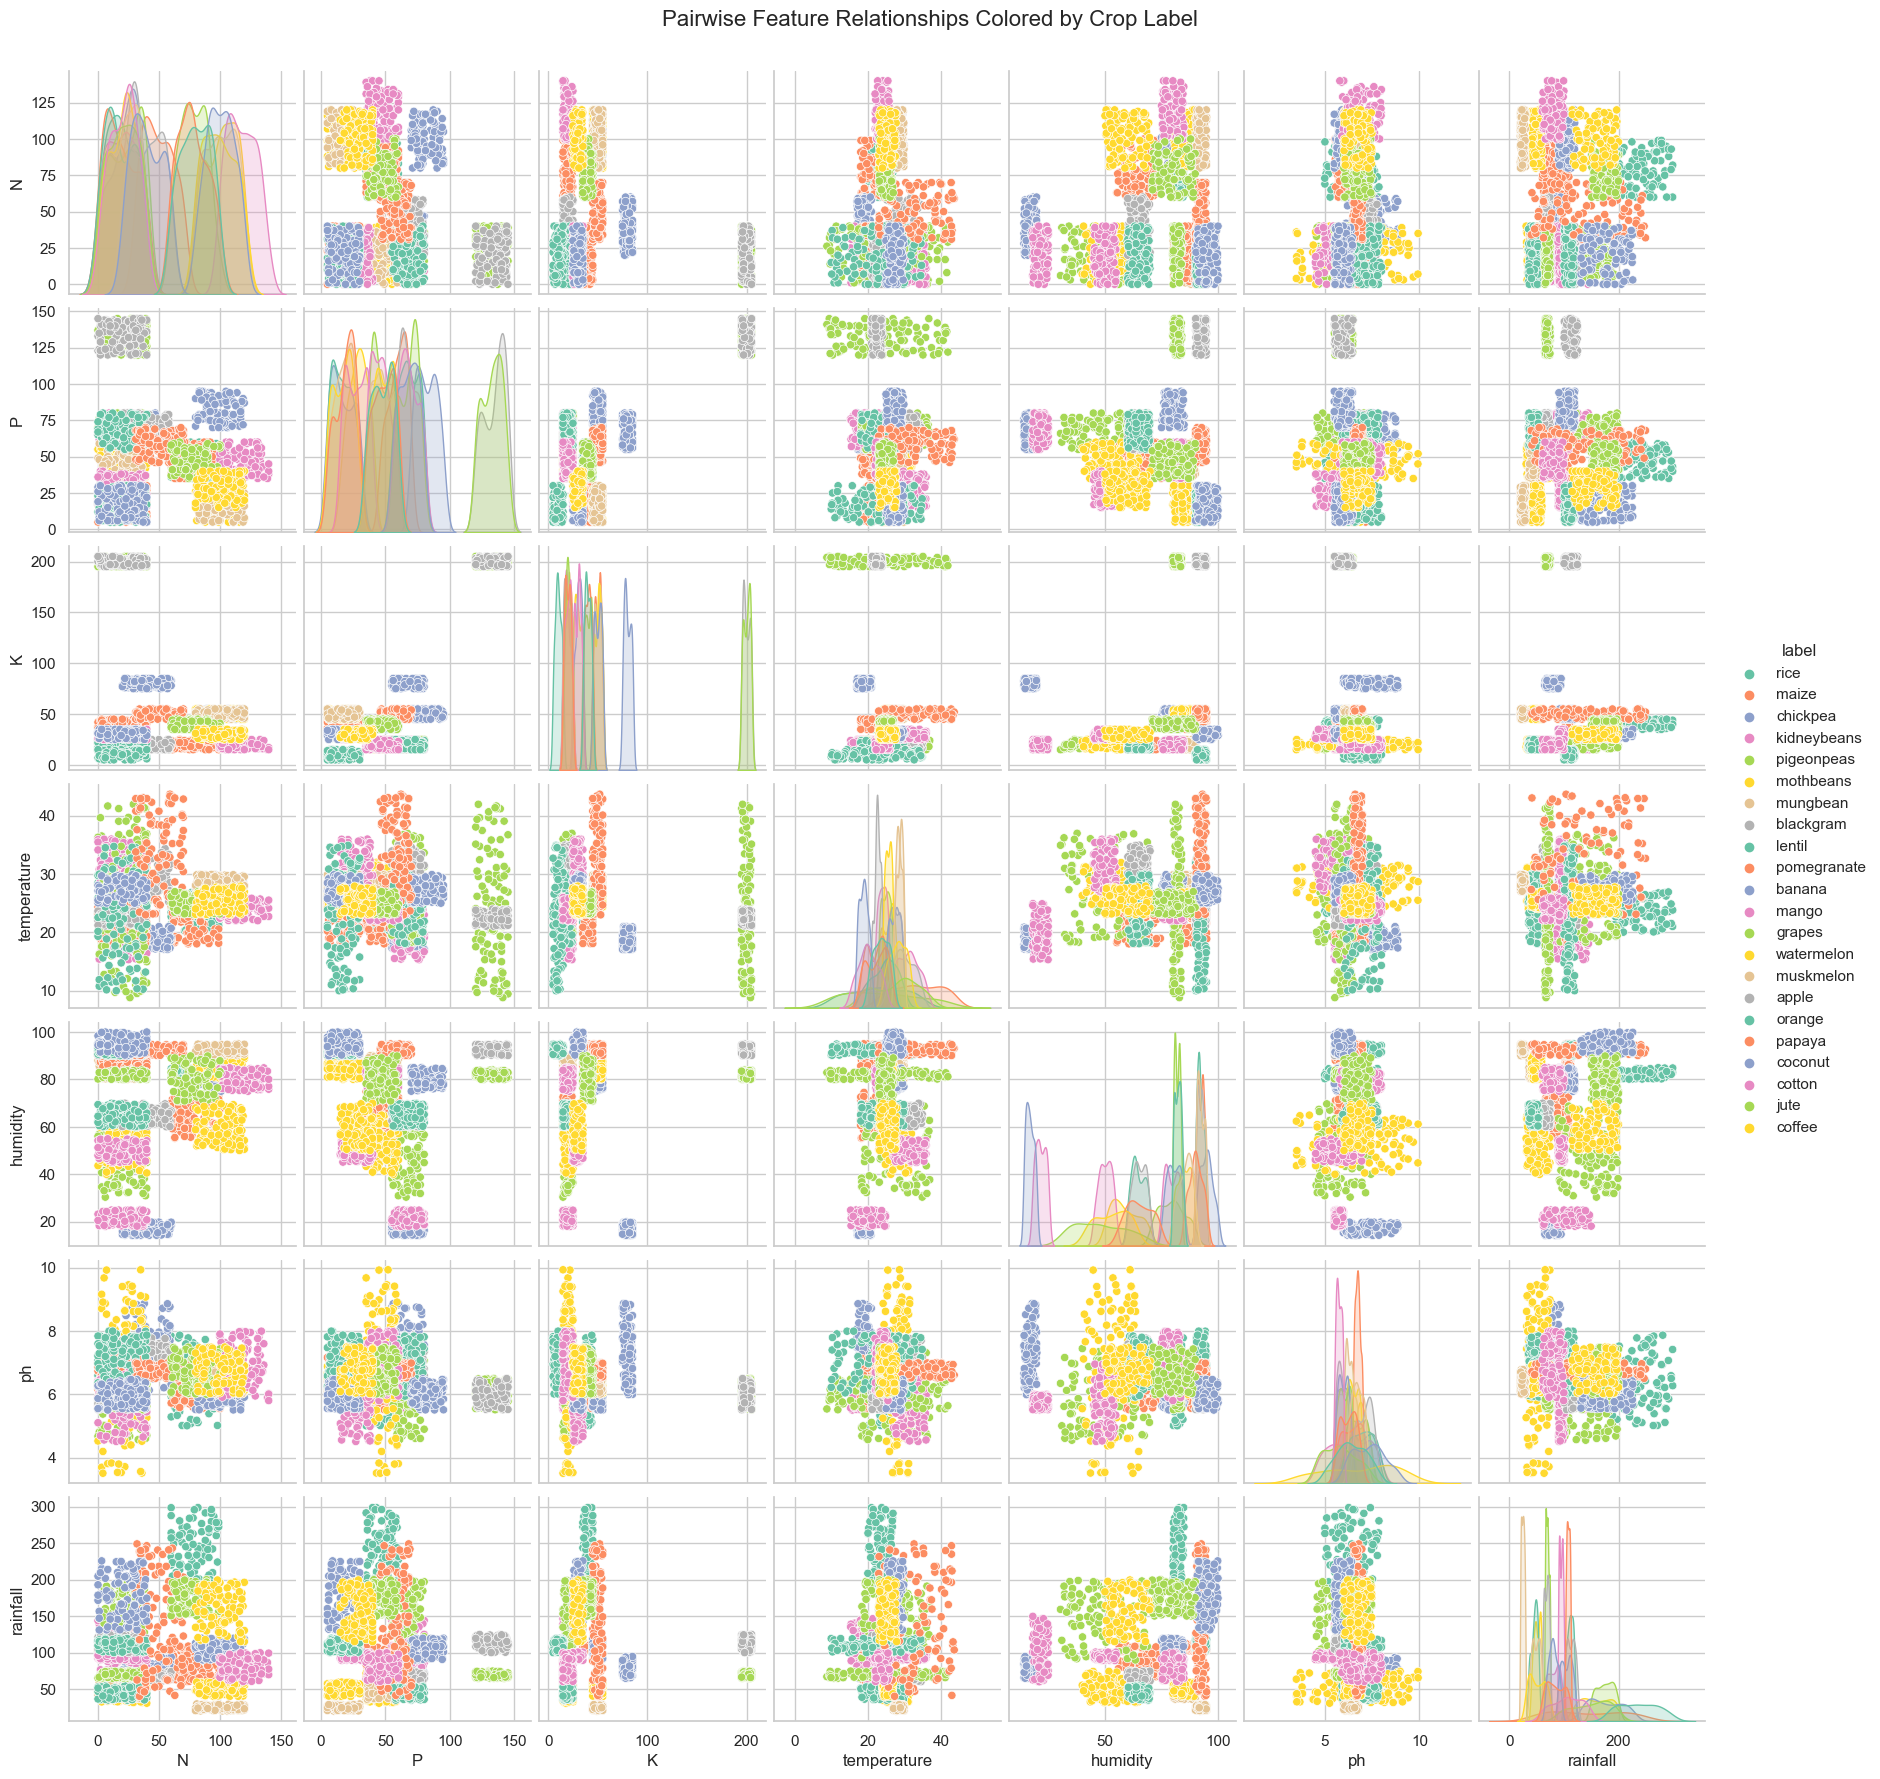

In [24]:

sns.pairplot(df, vars=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], hue='label', palette='Set2')

plt.suptitle('Pairwise Feature Relationships Colored by Crop Label', y=1.02, fontsize=16)
plt.show()


In [25]:
summary = pd.pivot_table(df, index = ['label'], aggfunc = 'mean')
summary

K        N        P   humidity        ph    rainfall  \
label                                                                     
apple        199.890   20.732  134.220  92.333383  5.929663  112.654779   
banana        50.050  100.248   82.010  80.358123  5.984033  104.626980   
blackgram     19.240   40.020   67.418  65.118426  7.133952   67.884151   
chickpea      79.928   40.090   67.790  16.860439  7.336957   80.058977   
coconut       30.618   21.980   16.934  94.844272  5.976562  175.686646   
coffee        29.964  101.330   28.740  58.869846  6.790308  158.066295   
cotton        19.560  117.866   46.240  79.843474  6.912675   80.398043   
grapes       200.110   23.122  132.530  81.875228  6.028187   69.611829   
jute          40.002   78.112   46.860  79.639864  6.726159  174.792798   
kidneybeans   20.064   20.750   67.722  21.605357  5.748527  105.919778   
lentil        19.410   18.770   68.360  64.804785  6.927932   45.680454   
maize         19.750   77.760   48.480  65.092249  6.243970   84.766988   
mango         29.884   20.070   27.180  50.156573  5.766373   94.704515   
mothbeans     20.230   21.440   48.010  53.160418  6.831174   51.198487   
mungbean      19.870   20.990   47.442  85.499975  6.723957   48.403601   
muskmelon     50.106  100.320   17.644  92.342802  6.355128   24.689952   
orange        10.010   19.452   16.550  92.170209  7.015996  110.474969   
papaya        50.040   49.666   59.050  92.403388  6.740345  142.627839   
pigeonpeas    20.290   20.730   67.724  48.061633  5.811949  149.457564   
pomegranate   40.210   18.870   18.750  90.125504  6.425251  107.528442   
rice          39.870   79.806   47.580  82.272822  6.420700  236.181114   
watermelon    50.222   99.420   17.074  85.160375  6.495778   50.786219   

             temperature  
label                     
apple          22.630942  
banana         27.376798  
blackgram      29.973340  
chickpea       18.872847  
coconut        27.409892  
coffee         25.540477  
cotton         23.988958  
grapes         23.849575  
jute           24.958376  
kidneybeans    20.115085  
lentil         24.509052  
maize          22.389204  
mango          31.208770  
mothbeans      28.194920  
mungbean       28.525775  
muskmelon      28.663066  
orange         22.765725  
papaya         33.723859  
pigeonpeas     27.741762  
pomegranate    21.837842  
rice           23.689332  
watermelon     25.591767

# Data preprocessing

In [26]:
def plot_distributions(df, cols):
    for col in cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()


In [27]:
def print_skewness(df, cols):
    print("Skewness of features:")
    print(df[cols].skew())

In [28]:
def hybrid_outlier_removal(df, cols):
    result = df.copy()
    for col in cols:
        skew = result[col].skew()
        if abs(skew) < 1:
            # Use Z-Score for nearly normal features
            z_scores = np.abs(stats.zscore(result[col]))
            result = result[z_scores < 3]
        else:
            # Use Modified Z-Score for skewed features
            median = np.median(result[col])
            mad = np.median(np.abs(result[col] - median))
            mzs = 0.6745 * (result[col] - median) / (mad + 1e-5)
            result = result[np.abs(mzs) < 3.5]
    return result

In [29]:
def multivariate_isolation_forest(df, cols, contamination=0.03):
    iso = IsolationForest(contamination=contamination, random_state=42)
    preds = iso.fit_predict(df[cols])
    return df[preds != -1]


In [30]:
def compare_boxplots(df_before, df_after, col):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(y=col, data=df_before, ax=axs[0], color='orange')
    axs[0].set_title('Before')
    sns.boxplot(y=col, data=df_after, ax=axs[1], color='lightgreen')
    axs[1].set_title('After')
    plt.suptitle(f'Outlier Impact on "{col}"', fontsize=14)
    plt.tight_layout()
    plt.show()

In [31]:
def enhanced_outlier_removal(df, cols, visualize=False):
    print("\n📊 Step 1: Checking skewness")
    print_skewness(df, cols)

    print("\n🔍 Step 2: Removing outliers with hybrid method...")
    df_hybrid = hybrid_outlier_removal(df.copy(), cols)
    print(f"✅ After hybrid method: {df_hybrid.shape[0]} rows")

    print("\n🌲 Step 3: Removing multivariate outliers using Isolation Forest...")
    df_final = multivariate_isolation_forest(df_hybrid.copy(), cols)
    print(f"✅ After Isolation Forest: {df_final.shape[0]} rows")

    if visualize:
        for col in cols:
            compare_boxplots(df, df_final, col)

    return df_final


📊 Step 1: Checking skewness
Skewness of features:
N              0.511835
P              1.009755
K              2.375022
temperature    0.184933
humidity      -1.091708
ph             0.290107
rainfall       0.965756
dtype: float64

🔍 Step 2: Removing outliers with hybrid method...
✅ After hybrid method: 1933 rows

🌲 Step 3: Removing multivariate outliers using Isolation Forest...
✅ After Isolation Forest: 1875 rows


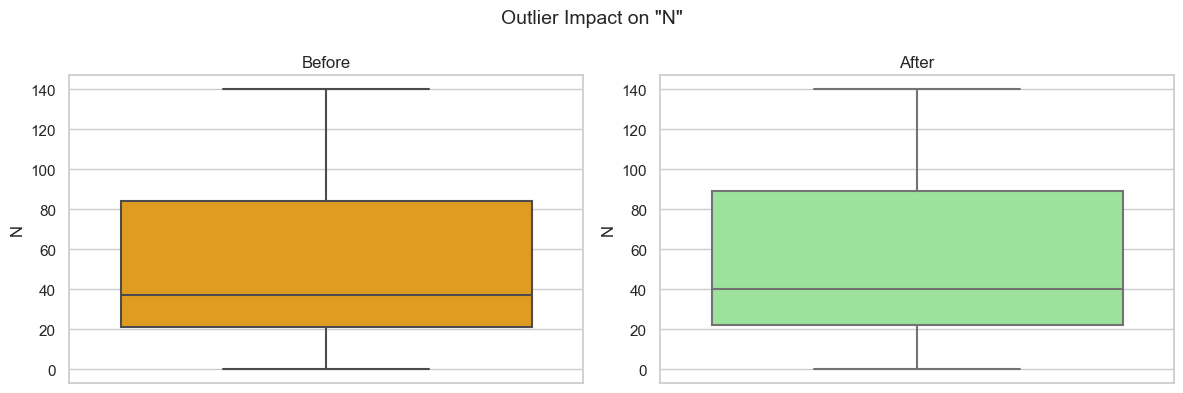

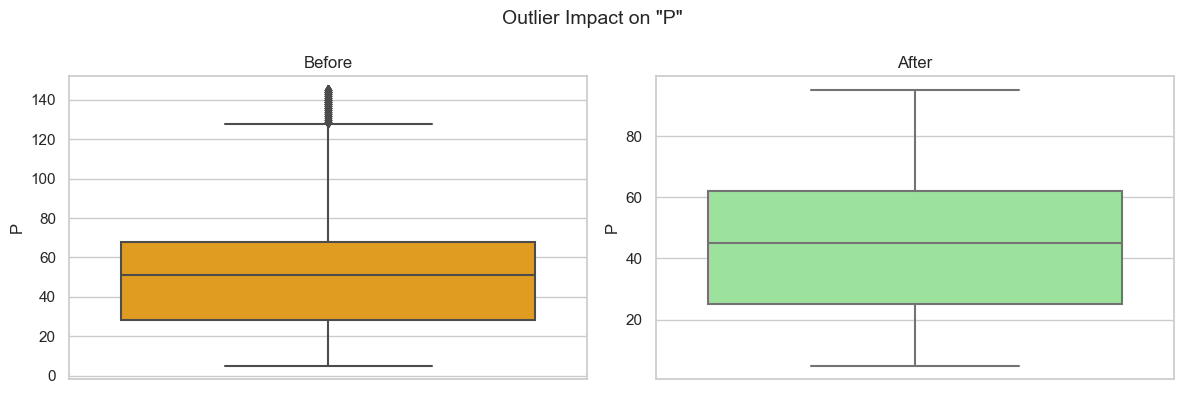

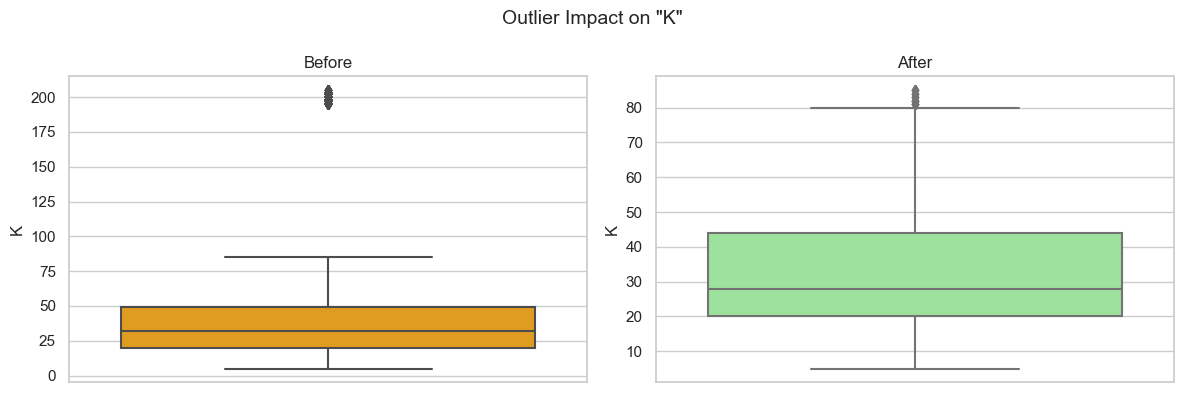

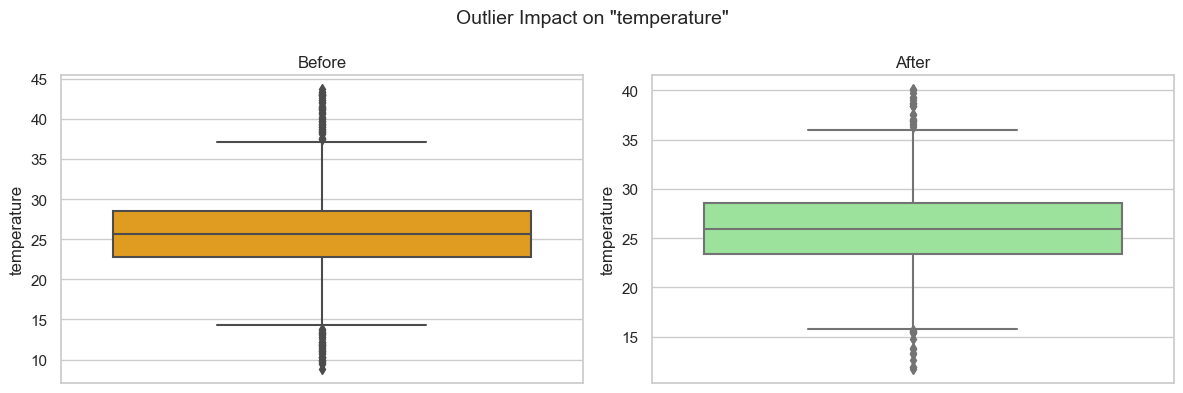

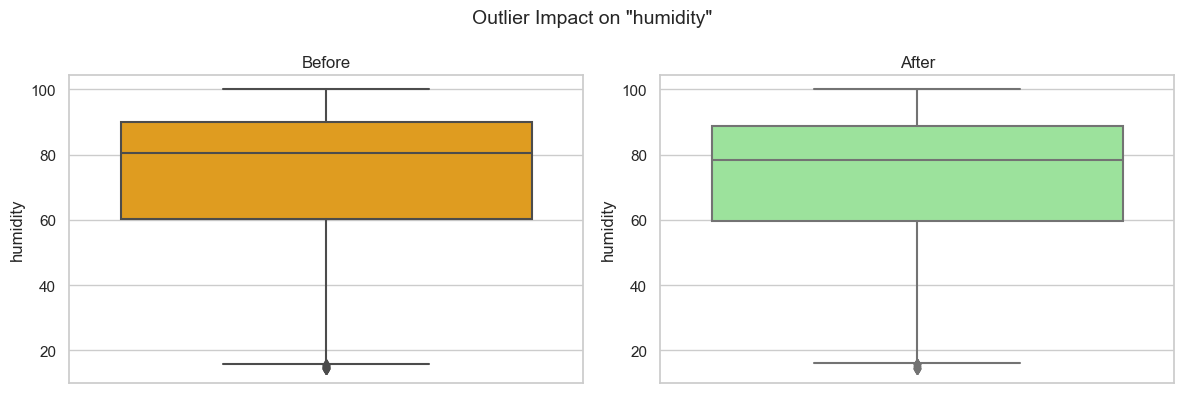

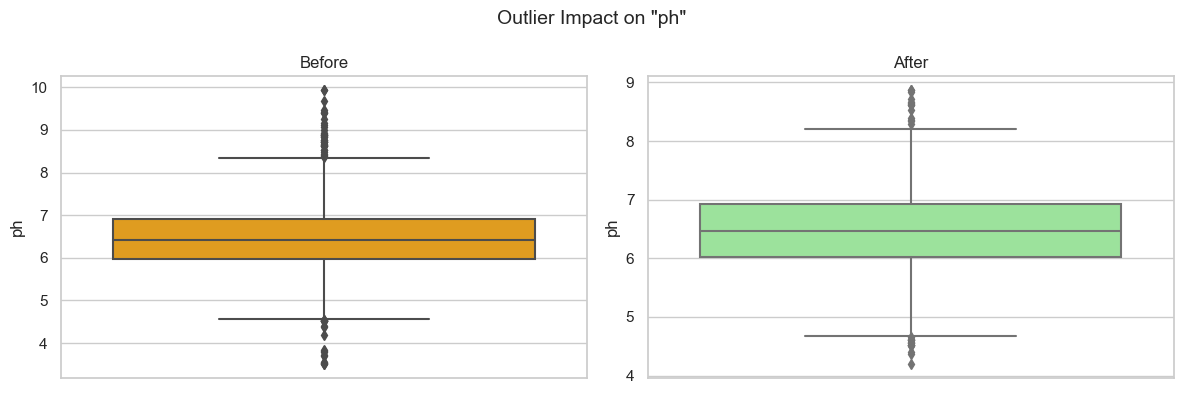

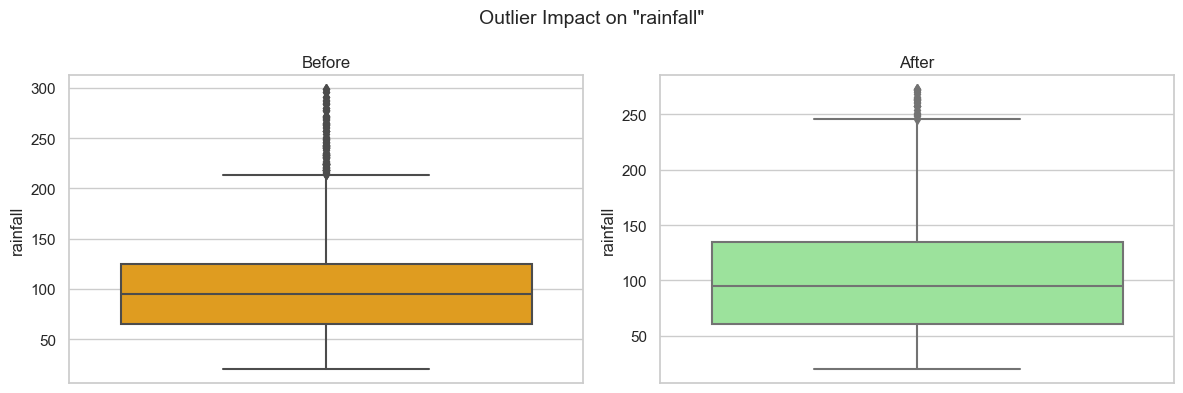

In [32]:
# Select numeric columns to check
cols_to_check = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Apply enhanced outlier cleaning
df_cleaned = enhanced_outlier_removal(df, cols_to_check, visualize=True)


In [33]:
def engineer_features(df):
    """
    Engineer new features from the existing dataset to capture interactions and non-linear relationships.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with original features

    Returns:
    - pd.DataFrame: DataFrame with engineered features
    """
    df = df.copy()

    # 1. Ratio-Based Features
    df['N_P_ratio'] = df['N'] / (df['P'] + 1e-5)  # Avoid division by zero
    df['N_K_ratio'] = df['N'] / (df['K'] + 1e-5)
    df['K_P_ratio'] = df['K'] / (df['P'] + 1e-5)

    # 2. Environmental Interaction Features
    df['rain_temp_ratio'] = df['rainfall'] / (df['temperature'] + 1e-5)
    df['humid_temp_ratio'] = df['humidity'] / (df['temperature'] + 1e-5)

    # 3. Non-linear (Polynomial) Features
    df['temp_squared'] = df['temperature'] ** 2
    df['rain_squared'] = df['rainfall'] ** 2
    df['ph_squared'] = df['ph'] ** 2

    # 4. pH Category Binning and One-Hot Encoding
    df['ph_bin'] = pd.cut(df['ph'], bins=[0, 5.5, 7.5, 14], labels=['Acidic', 'Neutral', 'Alkaline'])
    df = pd.get_dummies(df, columns=['ph_bin'], prefix='ph_type', drop_first=True)

    return df

In [34]:
df_fe = engineer_features(df)

print(df_fe.columns)


Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label',
       'N_P_ratio', 'N_K_ratio', 'K_P_ratio', 'rain_temp_ratio',
       'humid_temp_ratio', 'temp_squared', 'rain_squared', 'ph_squared',
       'ph_type_Neutral', 'ph_type_Alkaline'],
      dtype='object')


In [35]:
def encode_label(df, label_col='label'):
    """
    Encode the categorical target variable into numerical values.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with the target column
    - label_col (str): Name of the target column (default: 'label')

    Returns:
    - tuple: (DataFrame with encoded label, fitted LabelEncoder)
    """
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df[label_col])
    return df, le

In [36]:
def select_top_features(X, y, method='model', top_n=10):
    """
    Select the top features based on importance or recursive elimination.

    Parameters:
    - X (pd.DataFrame): Feature matrix
    - y (pd.Series): Target vector
    - method (str): 'model' for feature importance, 'rfe' for recursive feature elimination
    - top_n (int): Number of top features to select

    Returns:
    - list: Names of the top selected features
    """
    if method == 'model':
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), title='Feature Importance (Random Forest)')
        plt.show()
        top_features = importances.sort_values(ascending=False).head(top_n).index.tolist()
        return top_features

    elif method == 'rfe':
        model = RandomForestClassifier(random_state=42)
        rfe = RFE(model, n_features_to_select=top_n)
        rfe.fit(X, y)
        top_features = X.columns[rfe.support_].tolist()
        return top_features

    else:
        raise ValueError("Method must be 'model' or 'rfe'")

In [37]:
def full_preprocess_pipeline(df, label_col='label', top_n_features=12):
    """
    Complete preprocessing pipeline including feature engineering, encoding, splitting, imputation, scaling, and feature selection.

    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - label_col (str): Name of the target column (default: 'label')
    - top_n_features (int): Number of top features to select (default: 12)

    Returns:
    - tuple: (X_train_selected, X_test_selected, y_train, y_test, top_features, le, scaler)
    """
    print(" Engineering features...")
    df = engineer_features(df)

    print(" Encoding target variable...")
    df, le = encode_label(df, label_col)

    print(" Splitting features and target...")
    features = df.drop(columns=[label_col, 'label_encoded']) if label_col in df else df.drop(columns=['label_encoded'])
    target = df['label_encoded']

    print(" Splitting into Train/Test...")
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

    print(" Imputing missing values...")
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    print(" Scaling numeric features...")
    numeric_cols = X_train_imputed.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    print(" Selecting top features...")
    top_features = select_top_features(X_train_imputed, y_train, method='model', top_n=top_n_features)

    X_train_selected = X_train_imputed[top_features]
    X_test_selected = X_test_imputed[top_features]

    return X_train_selected, X_test_selected, y_train, y_test, top_features, le, scaler

Dataset shape: (2200, 8)

First few rows of the dataset:
      N     P     K  temperature   humidity        ph    rainfall label
0  90.0  42.0  43.0    20.879744  82.002744  6.502985  202.935536  rice
1  85.0  58.0  41.0    21.770462  80.319644  7.038096  226.655537  rice
2  60.0  55.0  44.0    23.004459  82.320763  7.840207  263.964248  rice
3  74.0  35.0  40.0    26.491096  80.158363  6.503336  242.864034  rice
4  78.0  42.0  42.0    20.130175  81.604873  7.628473  262.717340  rice
 Engineering features...
 Encoding target variable...
 Splitting features and target...
 Splitting into Train/Test...
 Imputing missing values...
 Scaling numeric features...
 Selecting top features...


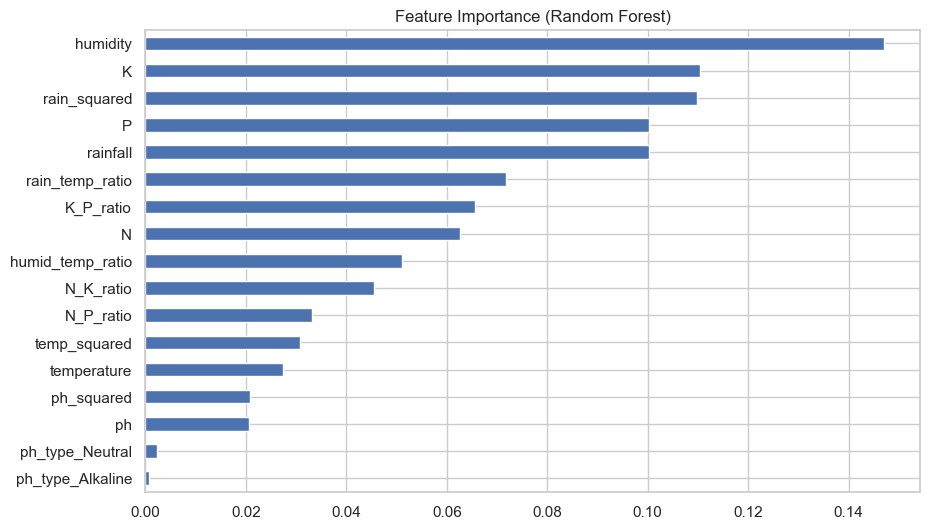


Top selected features: ['humidity', 'K', 'rain_squared', 'P', 'rainfall', 'rain_temp_ratio', 'K_P_ratio', 'N', 'humid_temp_ratio', 'N_K_ratio', 'N_P_ratio', 'temp_squared']

Training set shape after preprocessing: (1760, 12)
Testing set shape after preprocessing: (440, 12)


In [38]:
print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

    # Run the preprocessing pipeline
X_train, X_test, y_train, y_test, top_features, le, scaler = full_preprocess_pipeline(df)

    # Display results
print("\nTop selected features:", top_features)
print("\nTraining set shape after preprocessing:", X_train.shape)
print("Testing set shape after preprocessing:", X_test.shape)

In [39]:
X_train

humidity         K  rain_squared         P  rainfall  rain_temp_ratio  \
1607  0.924395 -0.673519     -0.042632 -1.073467  0.199440        -0.162337   
1212  0.426613  3.015238     -0.611713  2.084123 -0.643677        -0.814177   
362  -2.186291 -0.476259      0.425716  0.535690  0.694001         1.044109   
566  -0.459237 -0.594615     -0.837494 -0.466238 -1.231744        -1.212316   
1671  0.915842 -0.791875      0.035637 -1.255635  0.289941         2.220395   
...        ...       ...           ...       ...       ...              ...   
808  -0.396933 -0.555163     -0.833921  0.323160 -1.218366        -0.980862   
422  -1.087561 -0.574889      1.568134  0.049907  1.618598         2.374384   
2052  0.464759 -0.239547      1.589013 -0.162623  1.633233         1.379362   
2083  0.092922 -0.081740      1.054813 -0.101901  1.237246         0.905554   
1282  0.517450  2.995512     -0.625206  2.387738 -0.670771        -0.058152   

      K_P_ratio         N  humid_temp_ratio  N_K_ratio  N_P_ratio  \
1607  -0.305082 -1.370988          0.182086  -1.116100  -0.669852   
1212   0.348317 -1.126793         -0.122749  -1.086038  -0.640631   
362   -0.635438 -1.072527         -1.546289  -0.808385  -0.608484   
566   -0.533528 -0.339943         -0.473713   0.301256  -0.273744   
1671  -0.388553 -0.882598          3.784803   0.394502  -0.075690   
...         ...       ...               ...        ...        ...   
808   -0.654616 -1.018262          0.336271  -0.679704  -0.589393   
422   -0.629859 -0.936864         -0.397263  -0.550728  -0.554621   
2052  -0.325949  0.853899          0.250416   0.413153   0.006833   
2083  -0.228289  1.070961         -0.126817   0.257176   0.043143   
1282   0.248861 -1.343855          1.901010  -1.112743  -0.666852   

      temp_squared  
1607      0.758336  
1212      0.717872  
362      -0.869577  
566       0.039290  
1671     -1.937864  
...            ...  
808      -1.168801  
422      -1.110261  
2052     -0.060501  
2083      0.158766  
1282     -1.543484  

[1760 rows x 12 columns]

In [40]:
y_train

1607    16
1212     7
362      9
566     13
1671    16
        ..
808     10
422     18
2052     8
2083     8
1282     7
Name: label_encoded, Length: 1760, dtype: int32

In [41]:
X_test

humidity         K  rain_squared         P  rainfall  rain_temp_ratio  \
1609  0.846139 -0.831327     -0.213835 -0.921660 -0.013746         0.024729   
1072  0.586161  0.036616     -0.365460  0.778581 -0.225306        -0.267797   
1912  0.200508 -0.653793     -0.594525 -0.466238 -0.610000        -0.562796   
100  -0.346857 -0.634067     -0.405229  0.019545 -0.285429        -0.146414   
1645  0.920030 -0.831327     -0.018409 -0.952021  0.227863         0.211061   
...        ...       ...           ...       ...       ...              ...   
140   0.076965 -0.614341     -0.583522  0.080268 -0.588900        -0.540502   
1587  0.955554  3.054690     -0.052461  2.478822  0.187794         0.324301   
2015  0.352504 -0.259273      0.892129 -0.466238  1.106247         1.058753   
1254  0.386296  3.034964     -0.636531  2.448461 -0.693988         0.786828   
449  -1.566318 -0.456533      0.321852  0.414244  0.592868        -0.187278   

      K_P_ratio         N  humid_temp_ratio  N_K_ratio  N_P_ratio  \
1609  -0.693402 -1.018262          0.762217   0.338553  -0.445965   
1072  -0.413911  1.288023          0.390427   0.199803  -0.178478   
1912  -0.592836  2.427599          0.226721   5.150104   0.789494   
100   -0.666788  0.555439         -0.052819   1.863144  -0.149043   
1645  -0.684494 -0.285677          0.744089   3.359756   0.050344   
...         ...       ...               ...        ...        ...   
140   -0.661323  1.315156          0.133178   2.793696   0.030410   
1587   0.240261 -1.343855          1.021687  -1.112793  -0.666918   
2015  -0.197448  0.528306          0.318088   0.226658   0.059821   
1254   0.243085 -0.801200          3.930809  -1.046303  -0.607776   
449   -0.609065 -0.394208         -1.596557  -0.149314  -0.457018   

      temp_squared  
1609     -0.398182  
1072     -0.146185  
1912     -0.365065  
100      -0.630744  
1645     -0.294945  
...            ...  
140      -0.371984  
1587     -0.603004  
2015     -0.320094  
1254     -2.099191  
449       2.263073  

[440 rows x 12 columns]

In [42]:
y_test

1609    16
1072     1
1912     6
100     11
1645    16
        ..
140     11
1587     0
2015     8
1254     7
449     18
Name: label_encoded, Length: 440, dtype: int32

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Naive Bayes": GaussianNB()
}



🔍 Evaluating Logistic Regression
Accuracy: 0.9773, Precision: 0.9785, Recall: 0.9773, F1 Score: 0.9772
MCC: 0.9763, Kappa: 0.9762
ROC-AUC: 0.9998
Log Loss: 0.1576

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.91      1.00      0.95        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      1.00      1.00        20
          10       0.95      0.90      0.92        20
          11       1.00      0.90      0.95        20
          12       1.00      1.00      1.00        20
          13       0.90      0.95      0.93        20
  

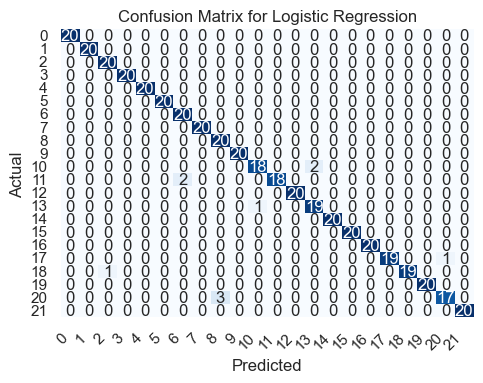



🔍 Evaluating Decision Tree
Accuracy: 0.9727, Precision: 0.9733, Recall: 0.9727, F1 Score: 0.9726
MCC: 0.9715, Kappa: 0.9714
ROC-AUC: 0.9857
Log Loss: 0.9830

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      0.85      0.92        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.86      0.90      0.88        20
           9       1.00      1.00      1.00        20
          10       0.95      0.95      0.95        20
          11       0.91      1.00      0.95        20
          12       0.95      1.00      0.98        20
          13       0.85      0.85      0.85        20
      

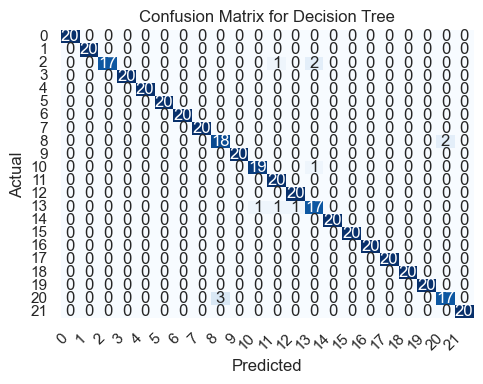



🔍 Evaluating Random Forest
Accuracy: 0.9841, Precision: 0.9860, Recall: 0.9841, F1 Score: 0.9841
MCC: 0.9834, Kappa: 0.9833
ROC-AUC: 1.0000
Log Loss: 0.0577

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      0.90      0.95        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      1.00      1.00        20
          10       1.00      0.90      0.95        20
          11       0.95      1.00      0.98        20
          12       1.00      1.00      1.00        20
          13       0.87      1.00      0.93        20
      

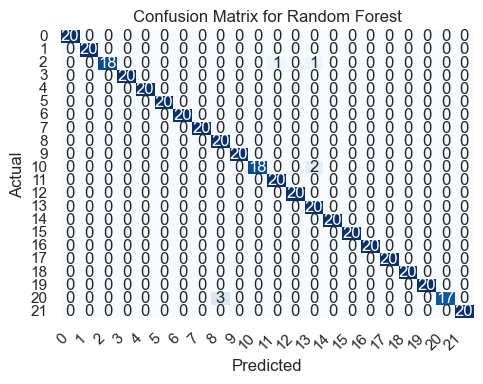



🔍 Evaluating SVC
Accuracy: 0.9795, Precision: 0.9811, Recall: 0.9795, F1 Score: 0.9795
MCC: 0.9787, Kappa: 0.9786
ROC-AUC: 0.9999
Log Loss: 0.1508

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      1.00      1.00        20
          10       0.95      0.95      0.95        20
          11       1.00      0.95      0.97        20
          12       1.00      1.00      1.00        20
          13       0.95      0.95      0.95        20
          14    

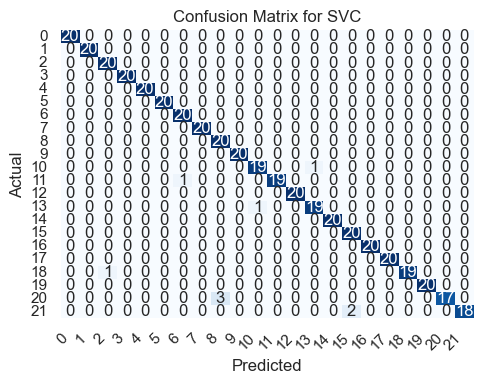



🔍 Evaluating XGBoost
Accuracy: 0.9818, Precision: 0.9835, Recall: 0.9818, F1 Score: 0.9818
MCC: 0.9810, Kappa: 0.9810
ROC-AUC: 0.9999
Log Loss: 0.0518

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.91      1.00      0.95        20
           9       1.00      1.00      1.00        20
          10       1.00      0.85      0.92        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       0.91      1.00      0.95        20
          14

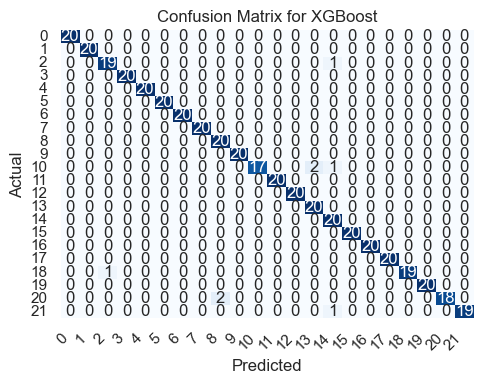



🔍 Evaluating Naive Bayes
Accuracy: 0.9886, Precision: 0.9897, Recall: 0.9886, F1 Score: 0.9886
MCC: 0.9882, Kappa: 0.9881
ROC-AUC: 0.9999
Log Loss: 0.0428

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.95      1.00      0.98        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      1.00      1.00        20
          10       1.00      0.95      0.97        20
          11       1.00      0.95      0.97        20
          12       1.00      1.00      1.00        20
          13       0.95      1.00      0.98        20
        

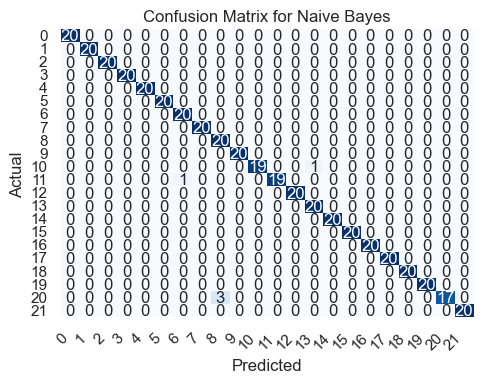

In [50]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, log_loss, matthews_corrcoef, cohen_kappa_score
)

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Probabilities for log loss & ROC AUC
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)
    except:
        pass  # Some models may not support predict_proba

    # Basic Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Advanced Metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted') if y_proba is not None else None
    logloss = log_loss(y_test, y_proba) if y_proba is not None else None

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'MCC': mcc,
        'Kappa': kappa,
        'ROC-AUC': roc,
        'Log Loss': logloss
    })

    # Print Metrics
    print(f"🔍 Evaluating {name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}, Kappa: {kappa:.4f}")
    if roc is not None:
        print(f"ROC-AUC: {roc:.4f}")
    if logloss is not None:
        print(f"Log Loss: {logloss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix with class labels
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))

    try:
        class_labels = model.classes_
    except AttributeError:
        class_labels = sorted(set(y_test))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=0.5 + np.arange(len(class_labels)), labels=class_labels, rotation=45, ha='right')
    plt.yticks(ticks=0.5 + np.arange(len(class_labels)), labels=class_labels, rotation=0)
    plt.tight_layout()
    plt.show()
    print('\n')


In [45]:
results_df = pd.DataFrame(results)
print("📋 Model Performance Comparison:")
display(results_df)

📋 Model Performance Comparison:


Model  Accuracy  Precision    Recall  F1 Score       MCC  \
0  Logistic Regression  0.977273   0.978528  0.977273  0.977225  0.976259   
1        Decision Tree  0.972727   0.972777  0.972727  0.972536  0.971450   
2        Random Forest  0.986364   0.986982  0.986364  0.986347  0.985746   
3                  SVC  0.979545   0.981064  0.979545  0.979493  0.978651   
4              XGBoost  0.981818   0.983534  0.981818  0.981818  0.981037   
5          Naive Bayes  0.988636   0.989742  0.988636  0.988595  0.988154   

      Kappa   ROC-AUC  Log Loss  
0  0.976190  0.999838  0.157625  
1  0.971429  0.985714  0.983009  
2  0.985714  0.999946  0.056577  
3  0.978571  0.999908  0.151802  
4  0.980952  0.999935  0.051761  
5  0.988095  0.999935  0.042825

C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\1030723759.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\rahul\AppData\Local\Temp\ipykernel_21352\1030723759.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
c:\Users\rahul\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


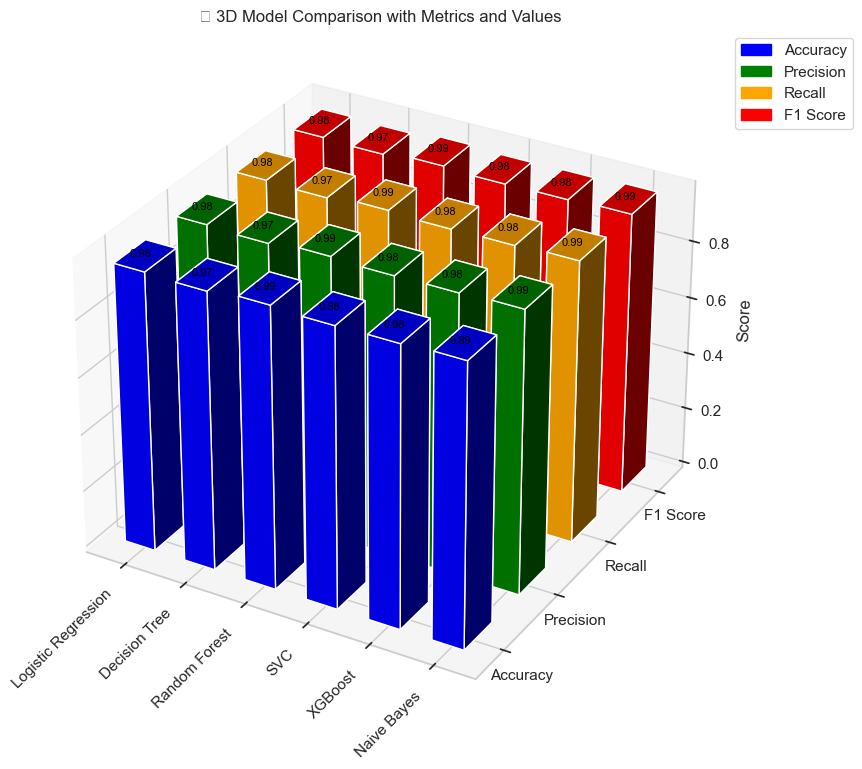

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Metrics and Models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = results_df['Model'].tolist()

# Metric colors
colors = {
    'Accuracy': 'blue',
    'Precision': 'green',
    'Recall': 'orange',
    'F1 Score': 'red'
}

# Mesh grid for placement
_x = np.arange(len(models))
_y = np.arange(len(metrics))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# Z values (flattened)
z = np.array([results_df[metric].values for metric in metrics])
z = z.ravel()

# Bar properties
dx = dy = 0.5
dz = z

# Bar colors based on metric
bar_colors = [colors[metrics[yi]] for yi in y]

# Plot
fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, color=bar_colors, shade=True)

# Add text labels on top of bars
for xi, yi, zi in zip(x, y, dz):
    ax.text(xi + dx/4, yi + dy/4, zi + 0.01, f'{zi:.2f}', color='black', fontsize=8)

# Set axes
ax.set_xticks(_x + dx / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_yticks(_y + dy / 2)
ax.set_yticklabels(metrics)
ax.set_zlabel('Score')
ax.set_title('📊 3D Model Comparison with Metrics and Values')

# Legend for metrics
legend_patches = [Patch(color=clr, label=metric) for metric, clr in colors.items()]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


✅ Stacked model saved as 'stacked_model.pkl'
✅ Stacked model loaded successfully!
🔍 Evaluating Stacking Model (Combining All Models)
Accuracy: 0.9909, Precision: 0.9919, Recall: 0.9909, F1 Score: 0.9909
MCC: 0.9905, Kappa: 0.9905
ROC-AUC: 1.0000
Log Loss: 0.0456

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.87      1.00      0.93        20
           9       1.00      1.00      1.00        20
          10       1.00      0.95      0.97        20
          11       1.00      1.00      1.00        20
          

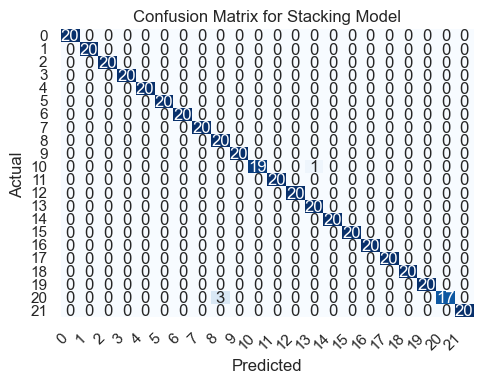

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving and loading the model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, log_loss, matthews_corrcoef, cohen_kappa_score
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Support Vector Classifier', SVC(probability=True)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Create stacking classifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False
)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(stack_model, "stacked_model.pkl")
print("✅ Stacked model saved as 'stacked_model.pkl'")

# Load the model later for inference
stack_model = joblib.load("stacked_model.pkl")
print("✅ Stacked model loaded successfully!")

# Evaluate the stacking model
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test) if hasattr(stack_model, 'predict_proba') else None

# Basic Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Advanced Metrics
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted') if y_proba is not None else None
logloss = log_loss(y_test, y_proba) if y_proba is not None else None

# Print results
print("🔍 Evaluating Stacking Model (Combining All Models)")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}, Kappa: {kappa:.4f}")
if roc is not None:
    print(f"ROC-AUC: {roc:.4f}")
if logloss is not None:
    print(f"Log Loss: {logloss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
class_labels = sorted(set(y_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Stacking Model")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=0.5 + np.arange(len(class_labels)), labels=class_labels, rotation=45, ha='right')
plt.yticks(ticks=0.5 + np.arange(len(class_labels)), labels=class_labels, rotation=0)
plt.tight_layout()
plt.show()


In [56]:
import numpy as np
import joblib

# Load the trained stacked model
stack_model = joblib.load("stacked_model.pkl")

# Crop mapping dictionary
crop_mapping = {
    1: 'rice', 2: 'maize', 3: 'chickpea', 4: 'kidneybeans', 5: 'pigeonpeas',
    6: 'mothbeans', 7: 'mungbean', 8: 'blackgram', 9: 'lentil', 10: 'pomegranate',
    11: 'banana', 12: 'mango', 13: 'grapes', 14: 'watermelon', 15: 'muskmelon',
    16: 'apple', 17: 'orange', 18: 'papaya', 19: 'coconut', 20: 'cotton',
    21: 'jute', 22: 'coffee'
}

# Crop advice dictionary
crop_advice = {
    "rice": "Ensure adequate water as rice requires flooded fields. Maintain warm temperatures and high humidity.",
    "maize": "Requires well-drained fertile soil. Ensure consistent watering and full sunlight.",
    "chickpea": "Needs cool weather and well-drained soil. Avoid waterlogging.",
    "kidneybeans": "Requires moderate rainfall and cool temperature. Avoid excessive nitrogen fertilizers.",
    "pigeonpeas": "Thrives in semi-arid conditions. Needs moderate water and rich soil.",
    "mothbeans": "Good for drought-prone areas. Needs minimal irrigation.",
    "mungbean": "Prefers hot and wet climate. Use organic fertilizers.",
    "blackgram": "Needs warm, moist conditions. Ensure timely irrigation during flowering.",
    "lentil": "Best in cool and dry climates. Avoid heavy clay soils.",
    "pomegranate": "Needs dry weather. Avoid over-irrigation to prevent root rot.",
    "banana": "Heavy feeder and water-demanding. Grow in rich, well-drained soil.",
    "mango": "Requires tropical/subtropical climate. Irrigate young plants regularly.",
    "grapes": "Require dry climate during ripening. Prune and train vines properly.",
    "watermelon": "Needs hot weather and sandy soil. Ensure deep watering.",
    "muskmelon": "Thrives in warm climates. Provide good drainage and avoid frost.",
    "apple": "Needs cold climate and chilling hours. Regular pruning is vital.",
    "orange": "Prefers subtropical climates. Requires regular watering and pest control.",
    "papaya": "Requires warm weather and protection from frost. Needs well-drained soil.",
    "coconut": "Needs high humidity and rainfall. Avoid water stagnation.",
    "cotton": "Requires high temperature and light rainfall. Good drainage is key.",
    "jute": "Needs warm, humid climate with plenty of water.",
    "coffee": "Needs warm and wet climate with shade. Avoid direct sunlight."
}

def compute_derived_features(N, P, K, temperature, humidity, pH, rainfall):
    """ Compute additional derived features """
    rain_squared = rainfall ** 2
    rain_temp_ratio = rainfall / temperature if temperature != 0 else 0
    K_P_ratio = K / P if P != 0 else 0
    humid_temp_ratio = humidity / temperature if temperature != 0 else 0
    N_K_ratio = N / K if K != 0 else 0
    N_P_ratio = N / P if P != 0 else 0
    temp_squared = temperature ** 2

    return np.array([humidity, K, rain_squared, P, rainfall, rain_temp_ratio, 
                     K_P_ratio, N, humid_temp_ratio, N_K_ratio, N_P_ratio, temp_squared])

def predict_crop(features):
    """
    Predicts the crop using the trained stacking model and provides advice.
    :param features: Input feature array (numpy array with 7 values)
    :return: Predicted crop name and advice
    """
    if stack_model is None:
        return "Model not found. Ensure it is loaded properly.", ""

    # Compute derived features
    extended_features = compute_derived_features(*features)

    # Make prediction
    predicted_label = stack_model.predict(extended_features.reshape(1, -1))[0]  # Get the predicted label directly
    
    # Convert label to crop name using crop_mapping
    crop_name = crop_mapping.get(predicted_label, "Unknown Crop") 
    
    # Provide advice
    advice = crop_advice.get(crop_name, "No specific advice available.")
    
    return crop_name, advice

# Example usage
example_features = np.array([60,55,44,23.00445915,82.3207629,7.840207144,263.9642476])  # N, P, K, temperature, humidity, pH, rainfall
predicted_crop, crop_suggestion = predict_crop(example_features)

print(f"Recommended Crop: {predicted_crop}")
print(f"Advice: {crop_suggestion}")


Recommended Crop: Unknown Crop
Advice: No specific advice available.


c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\rahul\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does n